Import required libraries

In [1]:
# !pip install numpy==1.21.0
# !pip install pandas==1.3.5
import pandas as pd
import os
%pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt_tab')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import re
import matplotlib.pyplot as plt
import sys


Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/samrawit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/samrawit/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/samrawit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /home/samrawit/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/samrawit/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [147]:
sys.path.append(os.path.abspath('../scripts'))
from utility import read_csv_file, clean_text, sentiment_analysis_parallel, preprocess_dataset, analyze_am_pm_distribution, analyze_topics_with_bertopic, analyze_email_domains, perform_topic_modeling, top_publishers, top_headline, analyze_headline_lengths, preprocess_stock_data, average_article_overtime
from plot import plot_bar, plot_pie, plot_stock_data, analyze_stock_data , plot_sentiment, plot_monthly_trends_overtime

Read dataset

In [3]:
all_data_path = '../data/raw_analyst_ratings.csv'
text_data = read_csv_file(all_data_path)

In [4]:
text_data = text_data.get("data")
text_data.head()

headline  \
0            Stocks That Hit 52-Week Highs On Friday   
1         Stocks That Hit 52-Week Highs On Wednesday   
2                      71 Biggest Movers From Friday   
3       46 Stocks Moving In Friday's Mid-Day Session   
4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00     A  
1  2020-06-03 10:45:20-04:00     A  
2  2020-05-26 04:30:07-04:00     A  
3  2020-05-22 12:45:06-04:00     A  
4  2020-05-22 11:38:59-04:00     A

In [5]:
text_data = preprocess_dataset(text_data, 'date')


In [6]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 12 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   headline     1407328 non-null  object        
 1   url          1407328 non-null  object        
 2   publisher    1407328 non-null  object        
 3   stock        1407328 non-null  object        
 4   Date         1407328 non-null  datetime64[ns]
 5   time         1407328 non-null  object        
 6   hour         1407328 non-null  int32         
 7   minute       1407328 non-null  int32         
 8   year         1407328 non-null  int32         
 9   month        1407328 non-null  int32         
 10  day          1407328 non-null  int32         
 11  day_of_week  1407328 non-null  object        
dtypes: datetime64[ns](1), int32(5), object(6)
memory usage: 102.0+ MB


In [7]:
unique_publishers = text_data['publisher'].nunique()

print(f"Total unique publishers: {unique_publishers}")

Total unique publishers: 1034


In [8]:

path = "../data/yfinance_data/"

# List of dataset file paths
dataset_files = ["AAPL_historical_data.csv", "AMZN_historical_data.csv", "GOOG_historical_data.csv", "META_historical_data.csv", "MSFT_historical_data.csv", "NVDA_historical_data.csv", "TSLA_historical_data.csv"]  # Add your dataset filenames here

# Corresponding variable names for each dataset
dataset_vars = ["AAPL", "AMZN", "GOOG", "META", "MSFT", "NVDA", "TSLA"]

# Dictionary to store processed DataFrames
processed_data = {}

# Loop through each dataset
for file_name, var_name in zip(dataset_files, dataset_vars):
    # Load the dataset
    try:
        print(f"Processing {path + file_name}...")
        df = read_csv_file(path + file_name)

        df = df.get("data")
        
        # Parse the Date column
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
        
        # Drop rows with invalid or missing Date
        df.dropna(subset=['Date'], inplace=True)
        
        # Select relevant columns
        selected_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
        missing_columns = [col for col in selected_columns if col not in df.columns]
        
        if missing_columns:
            print(f"Warning: {file_name} is missing columns: {missing_columns}")
            continue  # Skip this dataset
        
        df = df[selected_columns]

        # Preprocess the stock data
        df = preprocess_stock_data(df)
        
        # Dynamically assign the DataFrame to a variable
        globals()[var_name] = df
        
        # Store the processed DataFrame in the dictionary for additional access
        processed_data[var_name] = df
        
        # Display the first 5 rows
        print(f"First 5 rows of {var_name}:")
        print(df.tail())
    except Exception as e:
        print(f"An error occurred while processing {file_name}: {e}")




Processing ../data/yfinance_data/AAPL_historical_data.csv...
First 5 rows of AAPL:
            Date        Open        High         Low       Close   Adj Close  \
10993 2024-07-24  224.000000  224.800003  217.130005  218.539993  218.287323   
10994 2024-07-25  218.929993  220.850006  214.619995  217.490005  217.238556   
10995 2024-07-26  218.699997  219.490005  216.009995  217.960007  217.708008   
10996 2024-07-29  216.960007  219.300003  215.750000  218.240005  217.987686   
10997 2024-07-30  219.190002  220.330002  216.119995  218.800003  218.547043   

         Volume      SMA_50      EMA_50        RSI      MACD  MACD_signal  \
10993  61777600  208.474199  210.656039  48.687742  4.662717     6.678882   
10994  51391200  209.098399  210.924038  47.386437  3.748082     6.092722   
10995  41601300  209.709000  211.199958  48.055700  3.026267     5.479431   
10996  36311800  210.279400  211.476039  48.476184  2.448591     4.873263   
10997  41643800  210.858600  211.763253  49.359115 

Analysis

In [9]:
articles_per_day_of_week_avg, avg_article_per_month, avg_article_per_year, articles_per_year_total, articles_daily_avg, avg_articles_per_hour = average_article_overtime(text_data)


Average Articles Published Per Day of the Week (Monday to Sunday):
day_of_week
Monday       3156.714286
Tuesday      3529.404762
Wednesday    3582.619048
Thursday     3602.321429
Friday       2593.952381
Saturday       92.297619
Sunday        196.595238
dtype: float64

Average Articles Published Per Month:
month
1     893.683824
2     903.198529
3     896.676471
4     895.698529
5     958.375000
6     783.823529
7     814.426471
8     912.073529
9     706.522059
10    917.647059
11    892.875000
12    773.000000
dtype: float64

Average Articles Published Per Year:
year
2009      957.416667
2010     6776.583333
2011    10943.500000
2012    10221.250000
2013    10126.916667
2014    11238.250000
2015    11274.583333
2016    11824.333333
2017    10371.333333
2018    12243.666667
2019    12531.666667
2020     8767.833333
dtype: float64
\Total Articles Each Year:
year
2009     11489
2010     81319
2011    131322
2012    122655
2013    121523
2014    134859
2015    135295
2016    141892
2017

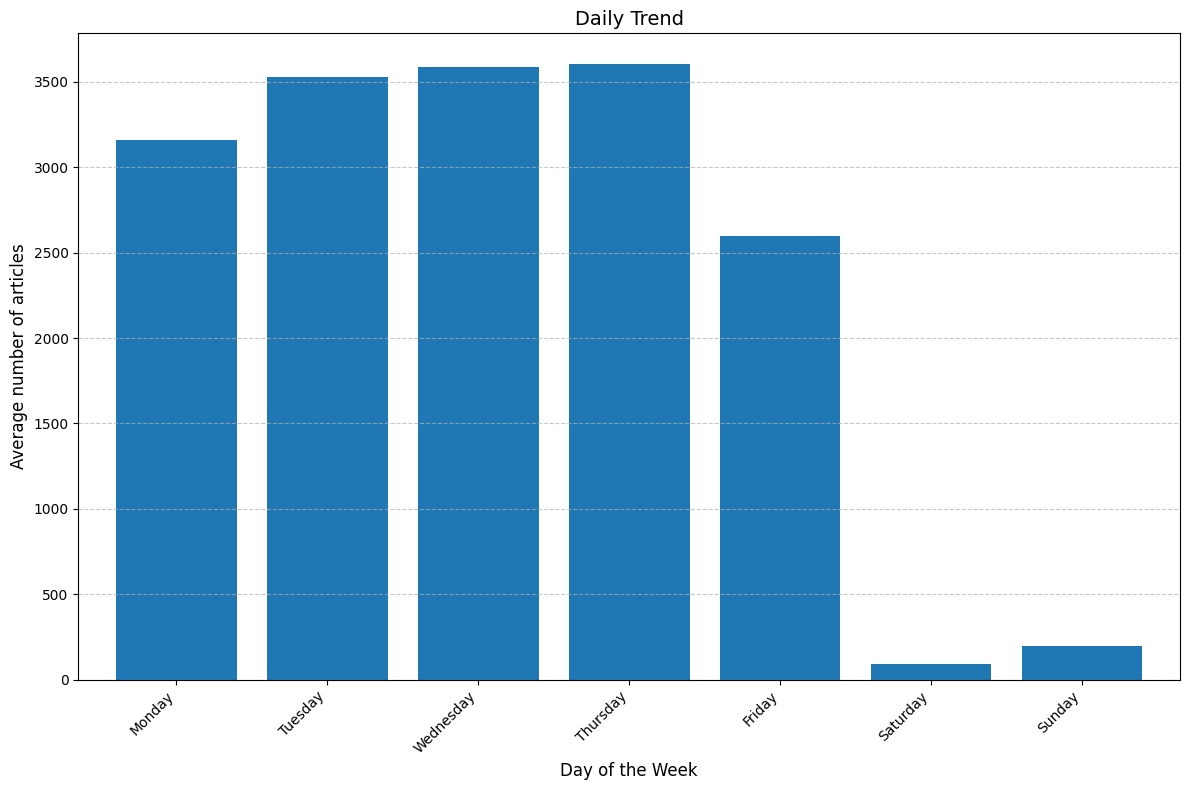

In [10]:
plot_bar(articles_per_day_of_week_avg, "Daily Trend", "Day of the Week", "Average number of articles" )

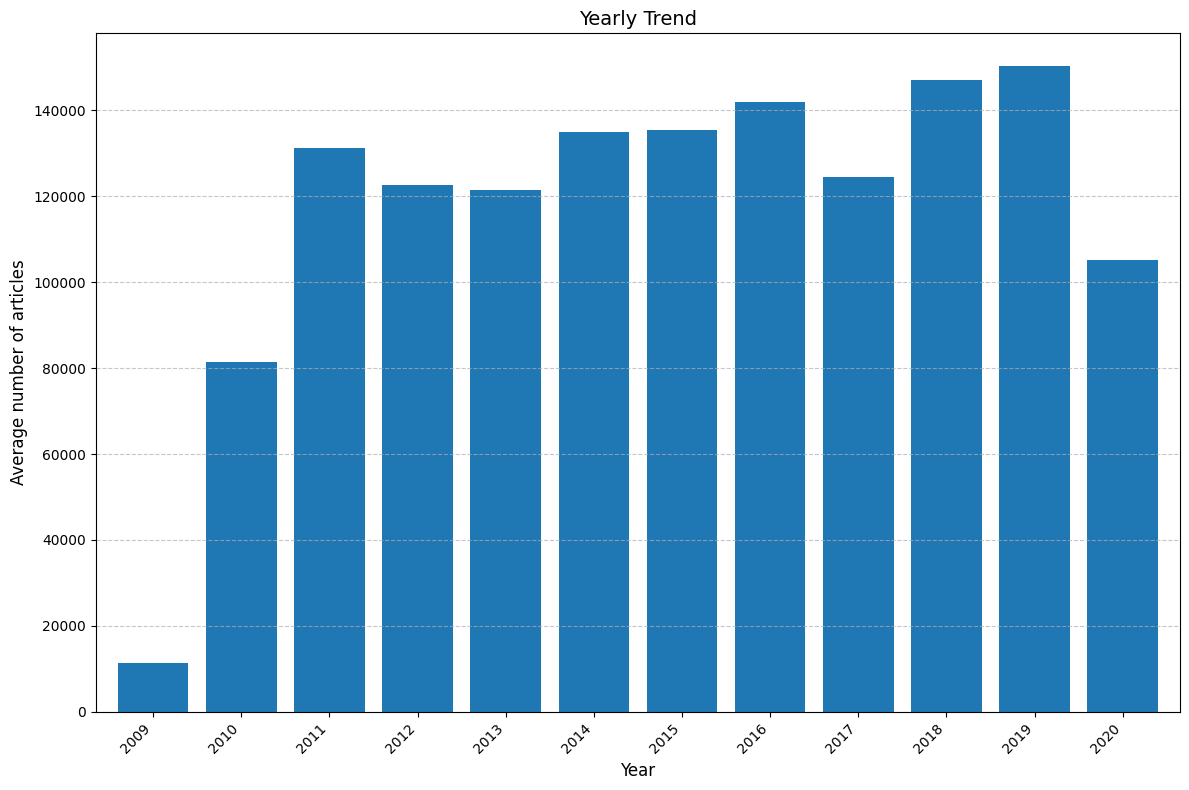

In [11]:
plot_bar(articles_per_year_total, "Yearly Trend", "Year", "Average number of articles" )

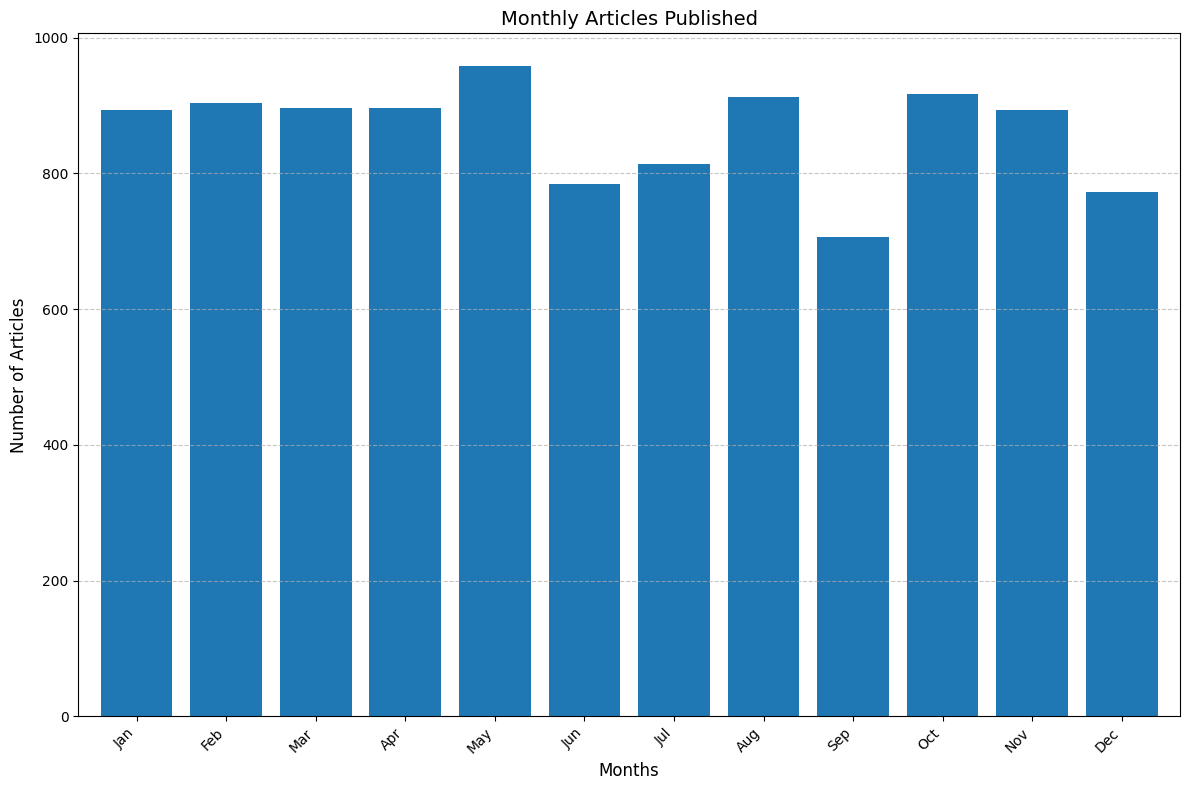

In [12]:
custom_ticks = range(12)  # Custom ticks, like the range of months
custom_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']  # Custom labels
rotation_angle = 45  # Rotation angle for the labels

# Call the function with the custom x-ticks and rotation
plot_bar(avg_article_per_month, title='Monthly Articles Published', xlabel='Months', ylabel='Number of Articles',
         custom_xticks=custom_labels, xtick_rotation=rotation_angle)


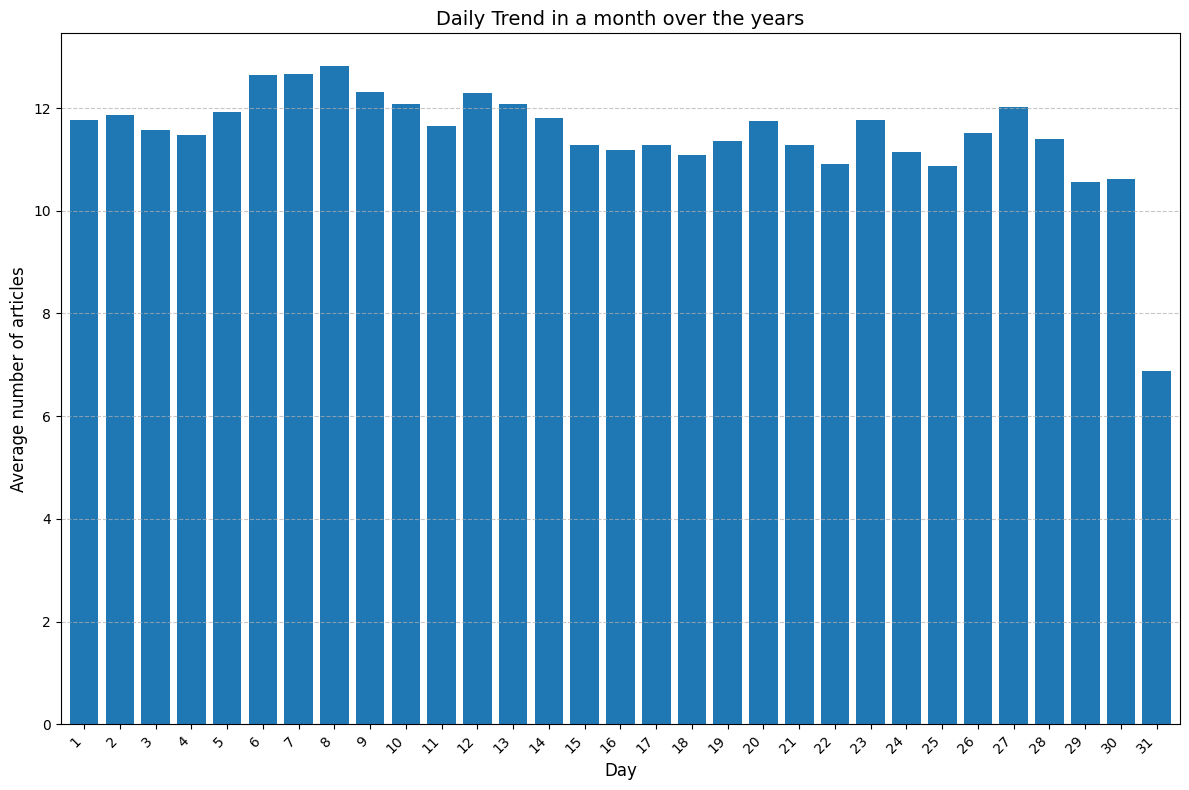

In [13]:
plot_bar(articles_daily_avg, "Daily Trend in a month over the years", "Day", "Average number of articles" )

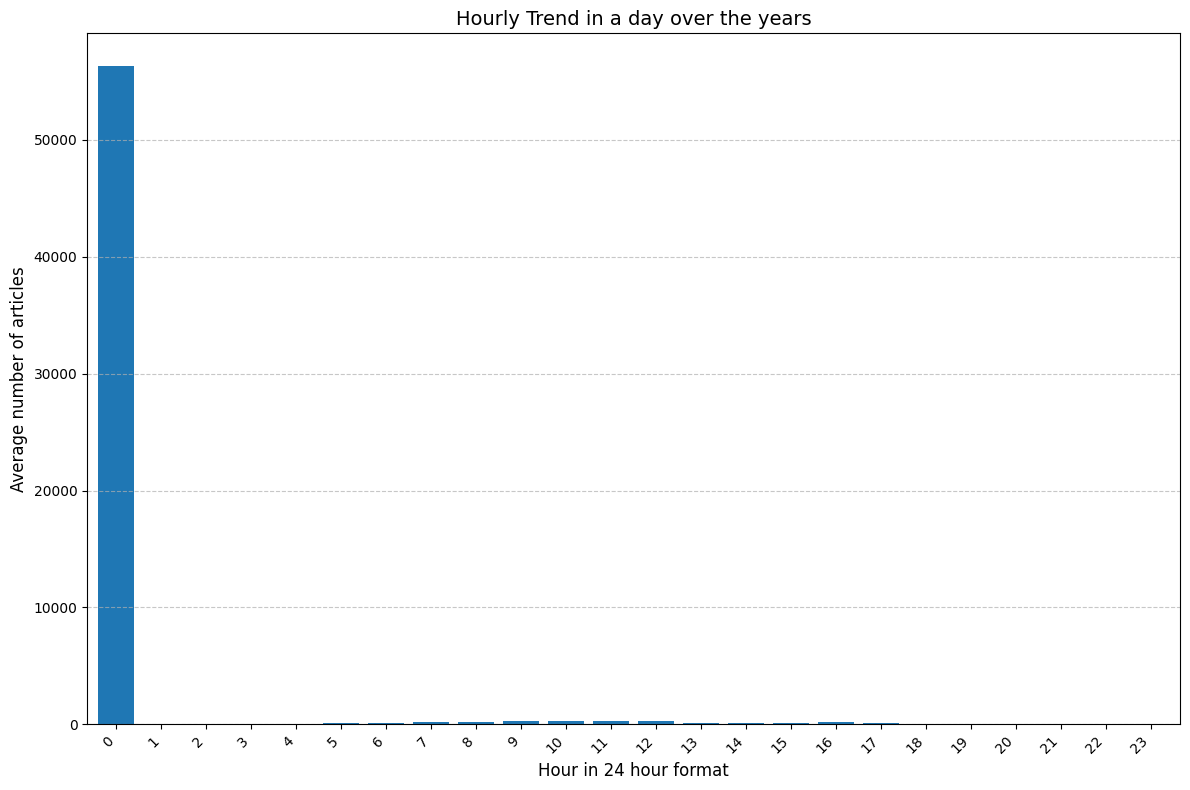

In [14]:
plot_bar(avg_articles_per_hour, "Hourly Trend in a day over the years", "Hour in 24 hour format", "Average number of articles" )

AM Articles: 57801.70833333332
PM Articles: 836.9583333333334


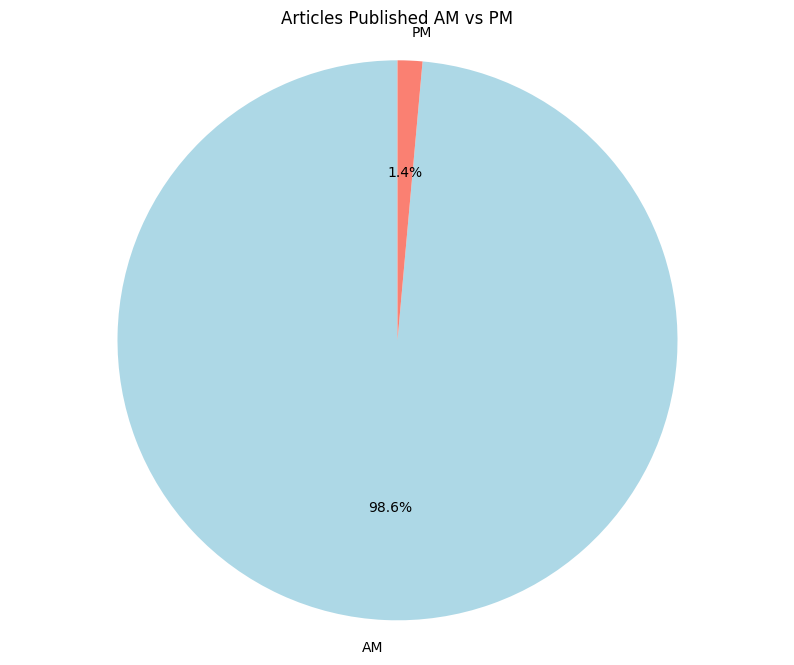

In [15]:
am_pm_distribution = analyze_am_pm_distribution(avg_articles_per_hour)

# Extract values and labels
values = list(am_pm_distribution.values())
labels = list(am_pm_distribution.keys())

# Plot the pie chart
plot_pie(values, title='Articles Published AM vs PM', labels=labels, autopct='%1.1f%%', colors=['lightblue', 'salmon'])

In [16]:
%pip install nbformat>=4.2.0

Note: you may need to restart the kernel to use updated packages.


In [17]:
text_data['headlineClean'] = text_data['headline'].apply(clean_text)

text_data[['headline', 'headlineClean']]

headline  \
0                  Stocks That Hit 52-Week Highs On Friday   
1               Stocks That Hit 52-Week Highs On Wednesday   
2                            71 Biggest Movers From Friday   
3             46 Stocks Moving In Friday's Mid-Day Session   
4        B of A Securities Maintains Neutral on Agilent...   
...                                                    ...   
1407323             Top Narrow Based Indexes For August 29   
1407324  Recap: Wednesday's Top Percentage Gainers and ...   
1407325  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1407326  Oppenheimer Initiates China Zenix At Outperfor...   
1407327  China Zenix Auto International Opens For Tradi...   

                                      headlineClean  
0                                    stock hit week  
1                                    stock hit week  
2                                           biggest  
3                       stock moving midday session  
4                              neutral price target  
...                                             ...  
1407323                     top narrow based august  
1407324                        recap top percentage  
1407325          update color china auto initiation  
1407326                            china outperform  
1407327  china auto international trading price set  

[1407328 rows x 2 columns]

In [18]:
analyze_topics_with_bertopic(text_data, 'headlineClean')


Top 10 Topics:
   Topic  Count                                 Name  \
0     -1    221       -1_hearing_money_capital_short   
1      0     42          0_agreement_merger_deal_bid   
2      1     38            1_target_price_buy_rating   
3      2     37        2_trading_several_higher_amid   
4      3     34  3_earnings_preview_quarter_previous   
5      4     32                4_yoy_year_last_prior   
6      5     32                5_hit_week_stock_post   
7      6     30               6_top_looking_bal_swan   
8      7     29     7_morgan_overweight_target_price   
9      8     28              8_like_dang_almost_dont   

                                      Representation  \
0  [hearing, money, capital, short, fast, potenti...   
1  [agreement, merger, deal, bid, patent, purchas...   
2  [target, price, buy, rating, coverage, brown, ...   
3  [trading, several, higher, amid, lower, recent...   
4  [earnings, preview, quarter, previous, second,...   
5  [yoy, year, last, prior, paci

{'topic_info':     Topic  Count                                      Name  \
 0      -1    221            -1_hearing_money_capital_short   
 1       0     42               0_agreement_merger_deal_bid   
 2       1     38                 1_target_price_buy_rating   
 3       2     37             2_trading_several_higher_amid   
 4       3     34       3_earnings_preview_quarter_previous   
 5       4     32                     4_yoy_year_last_prior   
 6       5     32                     5_hit_week_stock_post   
 7       6     30                    6_top_looking_bal_swan   
 8       7     29          7_morgan_overweight_target_price   
 9       8     28                   8_like_dang_almost_dont   
 10      9     28         9_neutral_analyst_tech_turnaround   
 11     10     27              10_moving_session_stock_move   
 12     11     27           11_hold_bank_lightning_mortgage   
 13     12     26               12_watch_june_stock_unusual   
 14     13     24               13_mornin

In [19]:
domain_counts = analyze_email_domains(text_data, 'publisher')


8 total unique email domains
Top domains:
publisher_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64


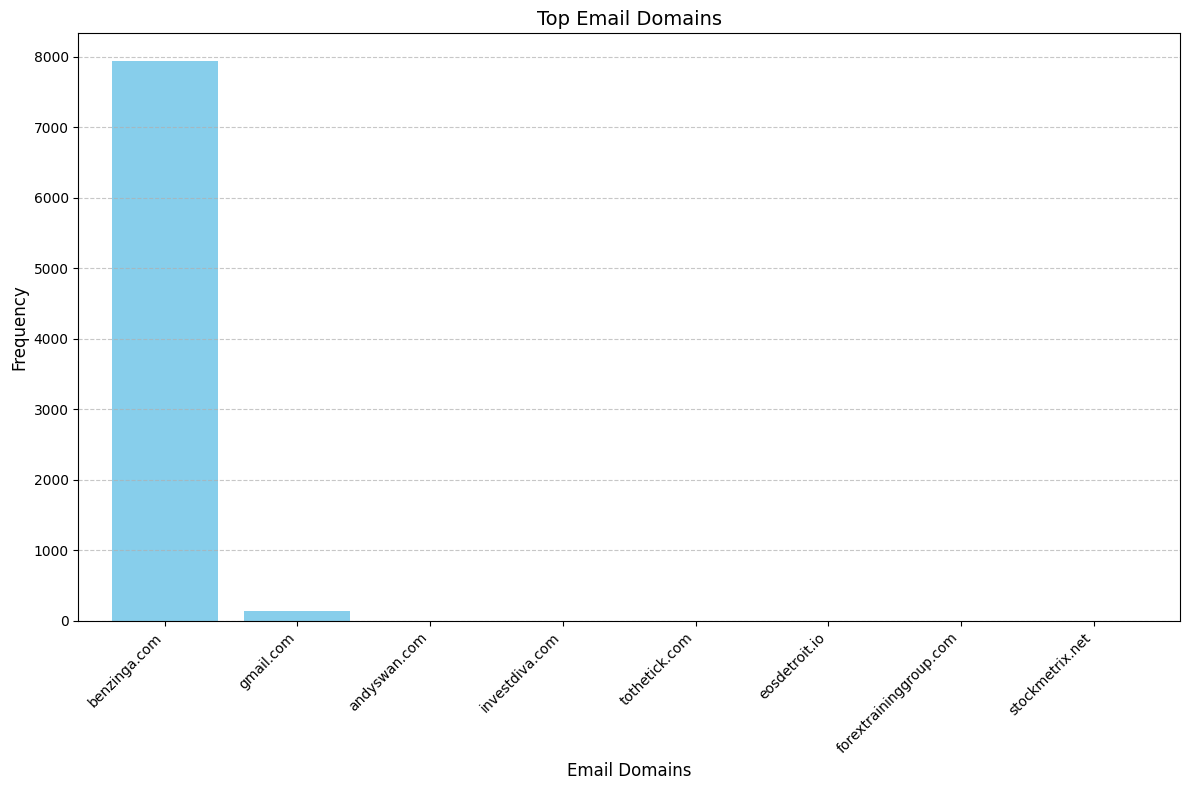

In [20]:
plot_bar(
    data=domain_counts,
    title='Top Email Domains',
    xlabel='Email Domains',
    ylabel='Frequency',
    colors=['skyblue'] * len(domain_counts),  # Customize colors (optional)
    custom_xticks=None,  # Let the function handle xticks
    xtick_rotation=45  # Rotate x-axis labels
)

In [21]:
# Perform topic modeling
sampled_data, topics = perform_topic_modeling(
    text_data, 
    column_name='headlineClean', 
    n_samples=1000, 
    n_topics=5, 
    n_terms=10
)
# Calculate dominant topic distribution
topic_counts = sampled_data['dominant_topic'].value_counts().sort_index()



Identified Topics:
Topic 1: trading, stock, notable, disclosed, outlook, today, research, lower, technology, common
Topic 2: earnings, market, buy, update, higher, company, coverage, trading, yoy, morning
Topic 3: revenue, estimate, share, year, neutral, corporation, update, dividend, following, beat
Topic 4: price, target, update, morgan, outperform, bank, biggest, option, hold, alert
Topic 5: stock, week, session, moving, new, hit, set, industry, high, midday
Results saved to 'headline_topics.csv'


In [22]:
print(type(topic_counts))

<class 'pandas.core.series.Series'>


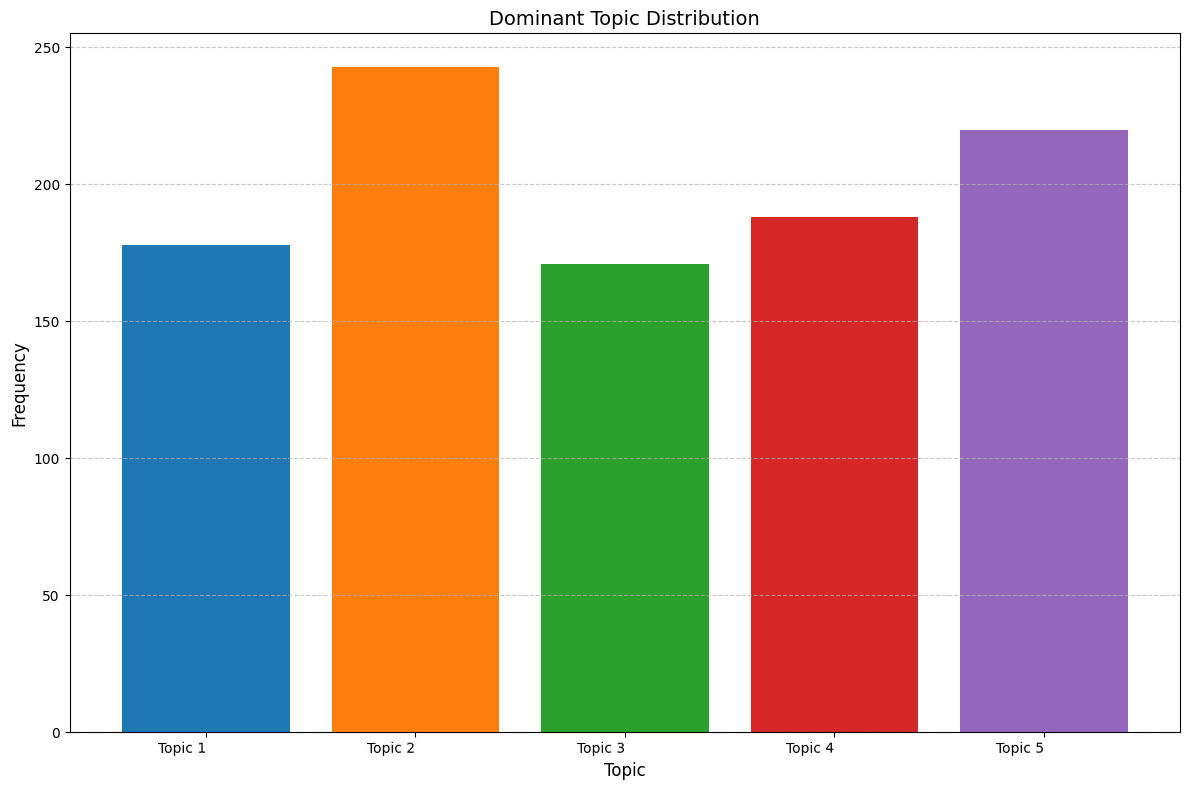

In [23]:
custom_labels = [f"Topic {i+1}" for i in topic_counts.index]

# Plot the distribution using plot_bar
plot_bar(
    data=topic_counts,
    title='Dominant Topic Distribution',
    xlabel='Topic',
    ylabel='Frequency',
    colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],  # Optional colors
    custom_xticks=(custom_labels),  # Use extracted labels
    xtick_rotation=0.4  # No rotation
   

)

Descriptive statistics for headline length

Headline Length Statistics:
 count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


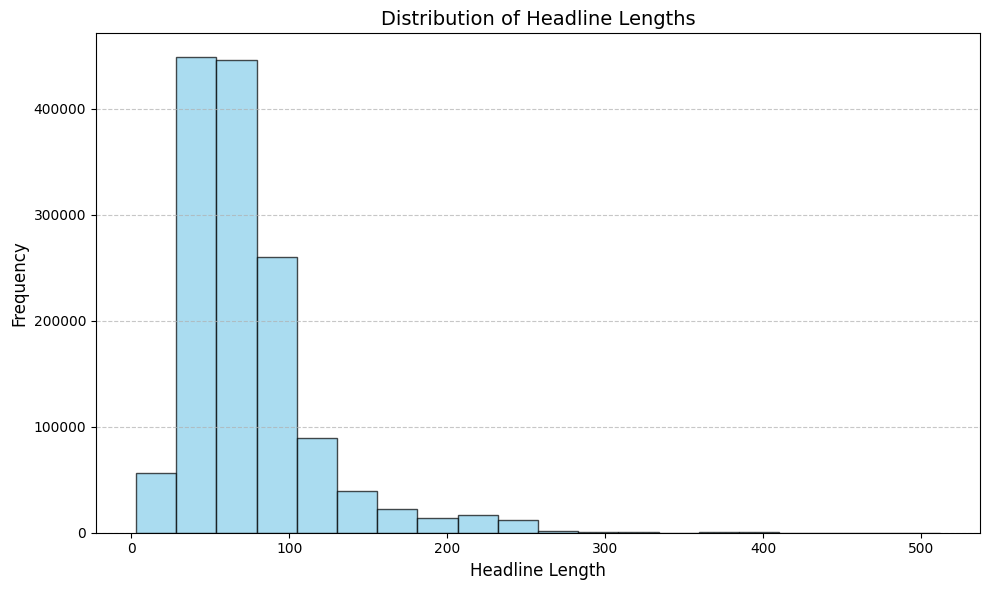

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

In [24]:
analyze_headline_lengths(text_data, 'headline')

The dataset contains headlines with an average length of 73 characters and a wide variability. Most headlines are within a reasonable range of 47 to 87 characters, balancing brevity and informativeness. Outliers exist, with very short and very long headlines, which may require further investigation.

Count Articles Per Publisher

Publishers who have contributed more than 1 article

In [25]:
articles_per_publisher = text_data['publisher'].value_counts()
# print("\nArticles Per Publisher:\n", articles_per_publisher)

# Filter publishers with more than 1 article
publishers_more_than_one = articles_per_publisher[articles_per_publisher > 1]

print("Publishers with More Than 1 Article:")
print(publishers_more_than_one)

Publishers with More Than 1 Article:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
                      ...  
Accointing                2
Niranjana Kannan          2
marketresearch            2
Brandon Vlaar             2
tsmartin                  2
Name: count, Length: 873, dtype: int64


In [26]:
top_15_publishers = top_publishers(text_data)

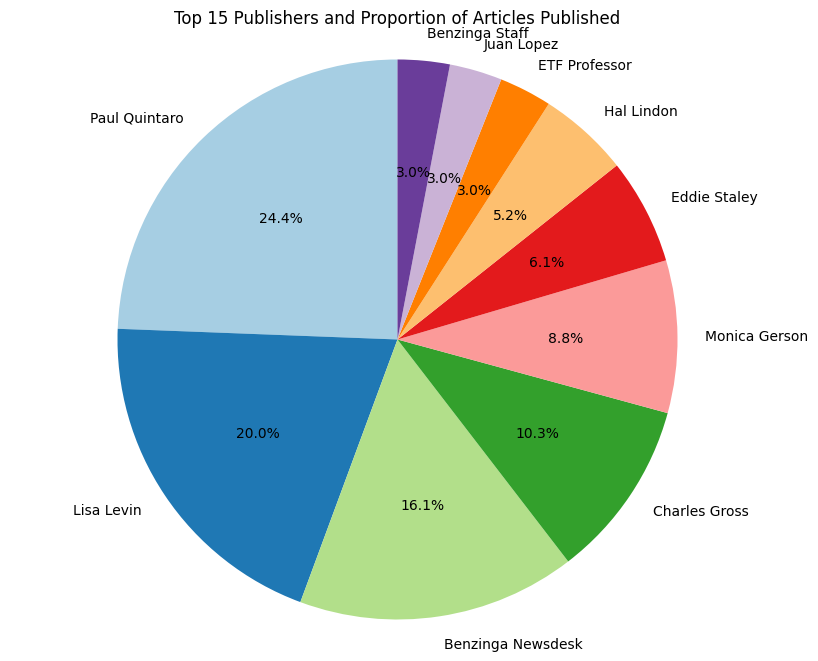

In [27]:
plot_pie(
    data=top_15_publishers,  # The data to be visualized
    title='Top 15 Publishers and Proportion of Articles Published',  # Title for the pie chart
    labels=top_15_publishers.index,  # Labels for the pie chart slices
    autopct='%1.1f%%',  # Display percentages on the pie slices
    colors=plt.cm.Paired.colors  # Optional color scheme
)

In [28]:
top_15_headlines = top_headline(text_data)

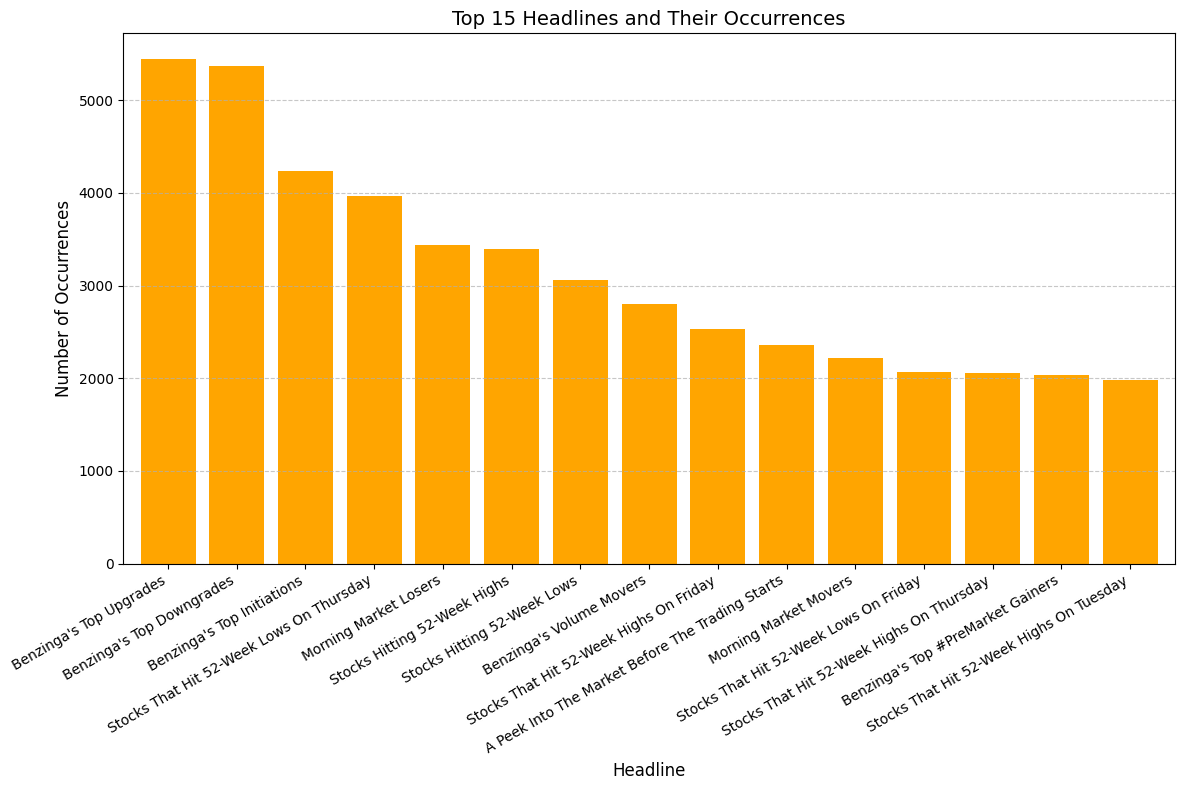

In [29]:
plot_bar(
    data=top_15_headlines,  # The data to be visualized
    title='Top 15 Headlines and Their Occurrences',  # Title for the bar chart
    xlabel='Headline',  # Label for the x-axis
    ylabel='Number of Occurrences',  # Label for the y-axis
    colors=['orange'],  # Bar color
    custom_xticks=top_15_headlines.index,  # Custom labels for x-ticks (headlines)
    xtick_rotation=30,  # Rotate labels for better readability
    grid=True  # Display gridlines
)

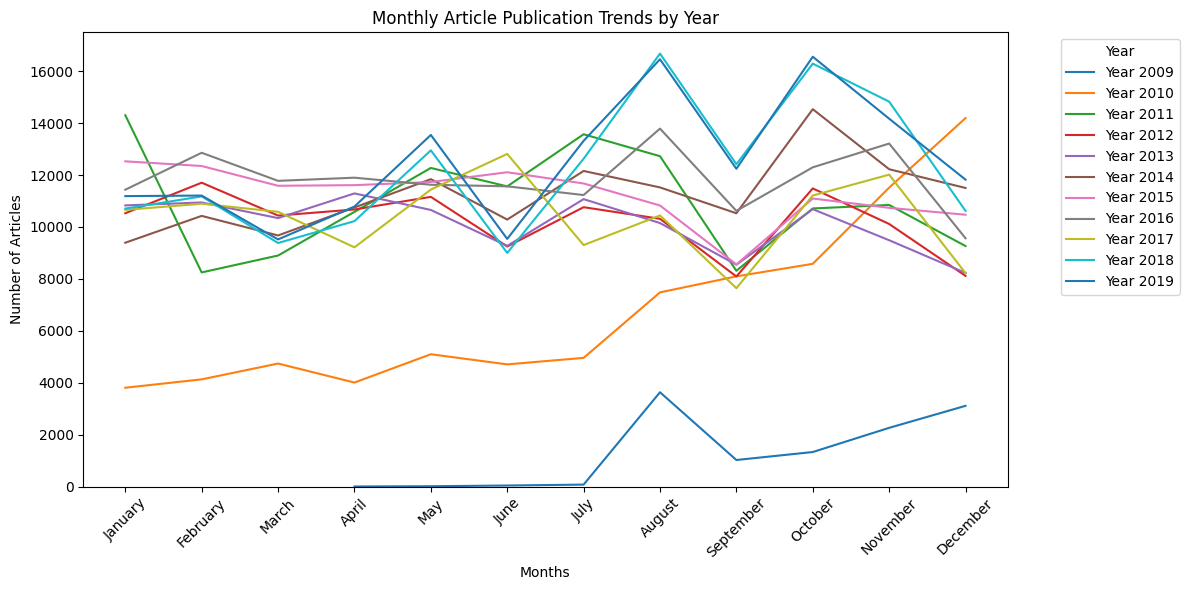

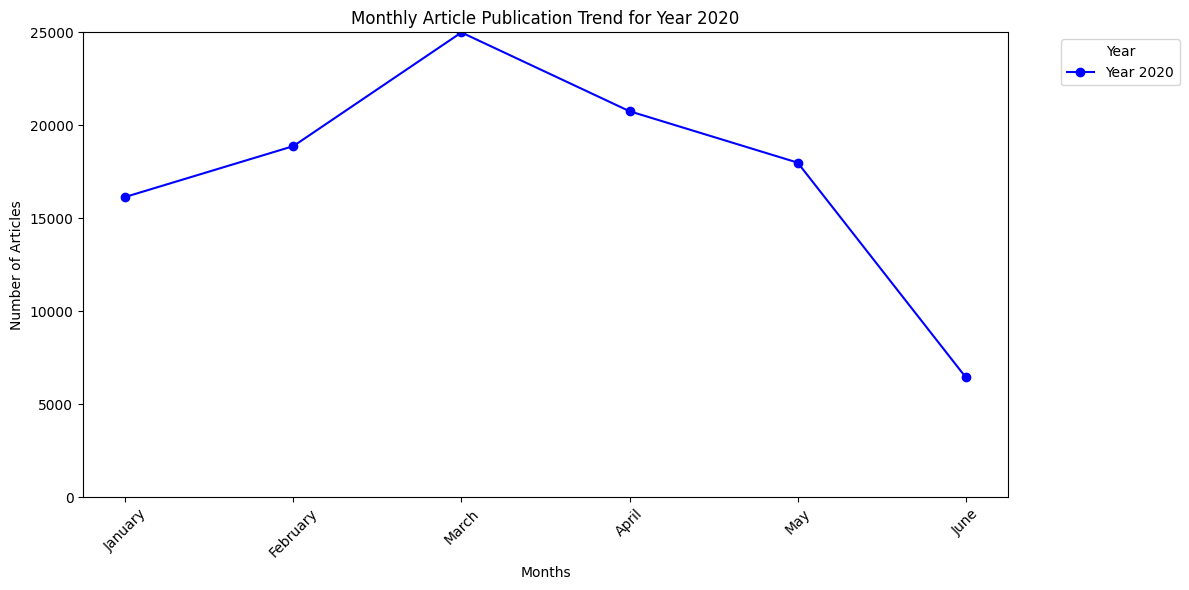

In [30]:
plot_monthly_trends_overtime(text_data, exclude_year=2020, ylim_overall=(0, 17500), ylim_2020=(0, 25000))

Get APPLE companies stock dataset

In [31]:
# Access the AAPL dataset
aapl_df = processed_data["AAPL"]

# Display the first 5 rows of the AAPL dataset
aapl_df.tail()

Date        Open        High         Low       Close   Adj Close  \
10993 2024-07-24  224.000000  224.800003  217.130005  218.539993  218.287323   
10994 2024-07-25  218.929993  220.850006  214.619995  217.490005  217.238556   
10995 2024-07-26  218.699997  219.490005  216.009995  217.960007  217.708008   
10996 2024-07-29  216.960007  219.300003  215.750000  218.240005  217.987686   
10997 2024-07-30  219.190002  220.330002  216.119995  218.800003  218.547043   

         Volume      SMA_50      EMA_50        RSI      MACD  MACD_signal  \
10993  61777600  208.474199  210.656039  48.687742  4.662717     6.678882   
10994  51391200  209.098399  210.924038  47.386437  3.748082     6.092722   
10995  41601300  209.709000  211.199958  48.055700  3.026267     5.479431   
10996  36311800  210.279400  211.476039  48.476184  2.448591     4.873263   
10997  41643800  210.858600  211.763253  49.359115  2.012764     4.301163   

       MACD_hist  
10993  -2.016164  
10994  -2.344640  
10995  -2.453164  
10996  -2.424672  
10997  -2.288399

In [32]:
aapl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10998 entries, 0 to 10997
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         10998 non-null  datetime64[ns]
 1   Open         10998 non-null  float64       
 2   High         10998 non-null  float64       
 3   Low          10998 non-null  float64       
 4   Close        10998 non-null  float64       
 5   Adj Close    10998 non-null  float64       
 6   Volume       10998 non-null  int64         
 7   SMA_50       10949 non-null  float64       
 8   EMA_50       10949 non-null  float64       
 9   RSI          10984 non-null  float64       
 10  MACD         10965 non-null  float64       
 11  MACD_signal  10965 non-null  float64       
 12  MACD_hist    10965 non-null  float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 1.1 MB


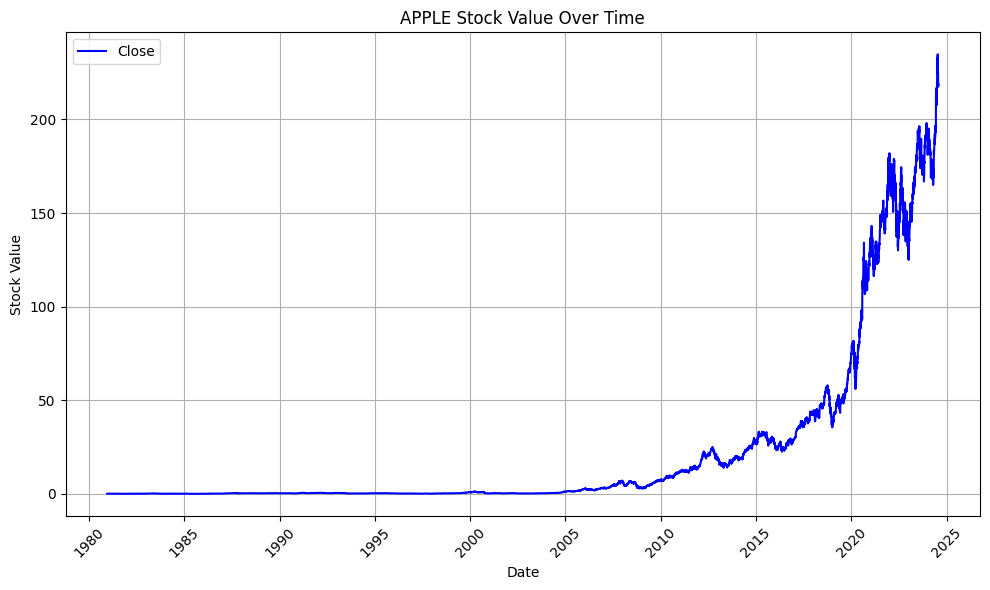

In [33]:
# Plot stock values for each company
plot_stock_data(aapl_df, date_column='Date', stock_value_column='Close', title=f'APPLE Stock Value Over Time')

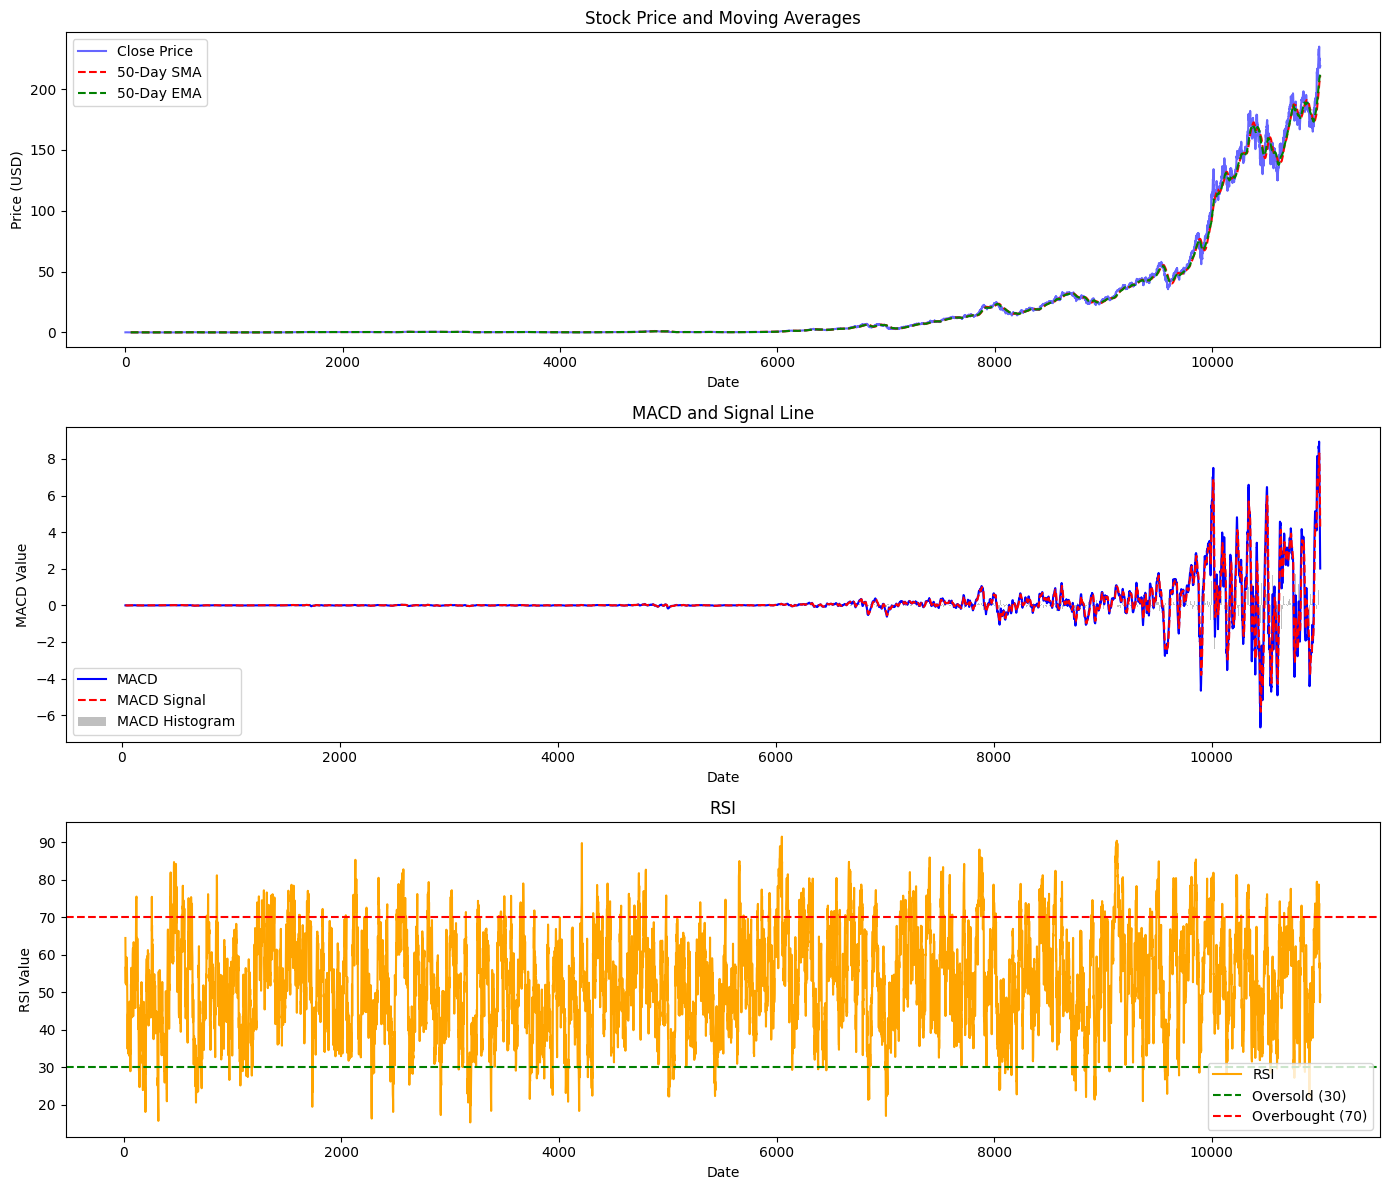

In [34]:
analyze_stock_data(aapl_df)


In [35]:
aapl_df.head()

Date      Open      High       Low     Close  Adj Close     Volume  \
0 1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1 1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
2 1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
3 1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
4 1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

   SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
0     NaN     NaN  NaN   NaN          NaN        NaN  
1     NaN     NaN  NaN   NaN          NaN        NaN  
2     NaN     NaN  NaN   NaN          NaN        NaN  
3     NaN     NaN  NaN   NaN          NaN        NaN  
4     NaN     NaN  NaN   NaN          NaN        NaN

In [36]:
# Ensure 'Date' column is in datetime format
text_data['Date'] = pd.to_datetime(text_data['Date'], errors='coerce')

# Set 'Date' as the index
text_data.set_index('Date', inplace=True)


# Ensure 'Date' column is in datetime format
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'], errors='coerce')

# Set 'Date' as the index
aapl_df.set_index('Date', inplace=True)

Merge AAPL with rating dataset

In [37]:
aapl_merged_data = pd.merge(text_data, aapl_df, left_on='Date', right_index=True, how='inner')


In [38]:
aapl_merged_data.head()

headline  \
Date                                                            
2020-06-05            Stocks That Hit 52-Week Highs On Friday   
2020-06-03         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26                      71 Biggest Movers From Friday   
2020-05-22       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22  B of A Securities Maintains Neutral on Agilent...   

                                                          url  \
Date                                                            
2020-06-05  https://www.benzinga.com/news/20/06/16190091/s...   
2020-06-03  https://www.benzinga.com/news/20/06/16170189/s...   
2020-05-26  https://www.benzinga.com/news/20/05/16103463/7...   
2020-05-22  https://www.benzinga.com/news/20/05/16095921/4...   
2020-05-22  https://www.benzinga.com/news/20/05/16095304/b...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-06-05  Benzinga Insights     A  10:30:54    10      30  2020      6    5   
2020-06-03  Benzinga Insights     A  10:45:20    10      45  2020      6    3   
2020-05-26         Lisa Levin     A  04:30:07     4      30  2020      5   26   
2020-05-22         Lisa Levin     A  12:45:06    12      45  2020      5   22   
2020-05-22         Vick Meyer     A  11:38:59    11      38  2020      5   22   

            ...        Low      Close  Adj Close     Volume    SMA_50  \
Date        ...                                                         
2020-06-05  ...  80.807503  82.875000  80.843407  137250400  72.79615   
2020-06-03  ...  80.574997  81.279999  79.287506  104491200  71.98905   
2020-05-26  ...  79.125000  79.182503  77.241432  125522000  69.56665   
2020-05-22  ...  78.837502  79.722504  77.768188   81803200  69.37285   
2020-05-22  ...  78.837502  79.722504  77.768188   81803200  69.37285   

               EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                
2020-06-05  75.199992  70.958079  2.314519     2.352009  -0.037490  
2020-06-03  74.654348  68.984470  2.304825     2.396276  -0.091451  
2020-05-26  73.139675  63.581835  2.569920     2.541397   0.028522  
2020-05-22  72.893029  65.837603  2.647354     2.534267   0.113087  
2020-05-22  72.893029  65.837603  2.647354     2.534267   0.113087  

[5 rows x 26 columns]

In [39]:
# Filter rows where 'headline' contains "AAPL"
aapl_related_data = aapl_merged_data[aapl_merged_data['headline'].str.contains("AAPL", case=False, na=False)]

# Display the filtered DataFrame
aapl_related_data

headline  \
Date                                                            
2009-08-27    China Unicom(CHU) to Launch Apple (AAPL) Iphone   
2011-06-23                At Least We Still Have Apple (AAPL)   
2011-01-11  Tuesday's Mid-Day Options Volume Leaders (BAC,...   
2011-01-10  Monday's Mid-Day Options Volume Leaders (C, AA...   
2011-01-07  Earnings For The S&P 500 Expected To Be Highes...   
...                                                       ...   
2010-02-03  Mad Money Lightning Round: Jim Prefers MRK, SY...   
2014-04-24  ETF Outlook for Thursday, April 24, 2014 (XLK,...   
2012-05-29  Stocks to Watch for the All Things Digital Con...   
2011-01-19  Claussen to WSJ: Apple (AAPL) Options Action A...   
2015-08-17  Quartz's Shelly Banjo Tweets: 'With purchase o...   

                                                          url  \
Date                                                            
2009-08-27  https://www.benzinga.com/benzingastaff1/2009/8...   
2011-06-23  https://www.benzinga.com/11/06/1204120/at-leas...   
2011-01-11  https://www.benzinga.com/options/11/01/770225/...   
2011-01-10  https://www.benzinga.com/options/11/01/766490/...   
2011-01-07  https://www.benzinga.com/news/11/01/761590/ear...   
...                                                       ...   
2010-02-03  https://www.benzinga.com/media/cnbc/109830/mad...   
2014-04-24  https://www.benzinga.com/etfs/sector-etfs/14/0...   
2012-05-29  https://www.benzinga.com/trading-ideas/long-id...   
2011-01-19  https://www.benzinga.com/11/01/791327/claussen...   
2015-08-17  https://www.benzinga.com/news/15/08/5770183/qu...   

                       publisher stock      time  hour  minute  year  month  \
Date                                                                          
2009-08-27        BenzingaStaff1     A  00:00:00     0       0  2009      8   
2011-06-23         Kevin McElroy    AA  00:00:00     0       0  2011      6   
2011-01-11  Michael J. Zerinskas    AA  00:00:00     0       0  2011      1   
2011-01-10  Michael J. Zerinskas    AA  00:00:00     0       0  2011      1   
2011-01-07         Roger Nachman    AA  00:00:00     0       0  2011      1   
...                          ...   ...       ...   ...     ...   ...    ...   
2010-02-03         Monica Gerson   ZMH  00:00:00     0       0  2010      2   
2014-04-24        Matthew McCall  ZNGA  00:00:00     0       0  2014      4   
2012-05-29             Alex Shek  ZNGA  00:00:00     0       0  2012      5   
2011-01-19         Options House   ZQK  00:00:00     0       0  2011      1   
2015-08-17         Paul Quintaro    ZU  00:00:00     0       0  2015      8   

            day  ...        Low      Close  Adj Close      Volume     SMA_50  \
Date             ...                                                           
2009-08-27   27  ...   5.886786   6.051786   5.110583   449181600   5.491636   
2011-06-23   23  ...  11.361429  11.829643   9.989842   559759200  12.076571   
2011-01-11   11  ...  12.123929  12.201429  10.303806   444108000  11.403457   
2011-01-10   10  ...  12.041786  12.230357  10.328234   448560000  11.374414   
2011-01-07    7  ...  11.853571  12.004286  10.137321   311931200  11.347836   
...         ...  ...        ...        ...        ...         ...        ...   
2010-02-03    3  ...   6.943571   7.115357   6.008742   615328000   7.234529   
2014-04-24   24  ...  20.026072  20.277500  17.815914   759911600  18.997557   
2012-05-29   29  ...  20.189644  20.438213  17.259563   380508800  21.028150   
2011-01-19   19  ...  12.031429  12.101429  10.219356  1135612800  11.515121   
2015-08-17   17  ...  28.875000  29.290001  26.451382   163538800  30.981750   

               EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                
2009-08-27   5.553394  63.751157  0.141486     0.155627  -0.014141  
2011-06-23  11.984296  49.370062 -0.156476    -0.148696  -0.007780  
2011-01-11  11.3

In [148]:
os.environ["TOKENIZERS_PARALLELISM"] = "true"


In [151]:
sentiment_analysis_parallel(aapl_related_data, 'headlineClean')

[('neutral', 0.0), ('negative', -0.3), ('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0)]


headline  \
Date                                                            
2009-08-27    China Unicom(CHU) to Launch Apple (AAPL) Iphone   
2011-06-23                At Least We Still Have Apple (AAPL)   
2011-01-11  Tuesday's Mid-Day Options Volume Leaders (BAC,...   
2011-01-10  Monday's Mid-Day Options Volume Leaders (C, AA...   
2011-01-07  Earnings For The S&P 500 Expected To Be Highes...   
...                                                       ...   
2010-02-03  Mad Money Lightning Round: Jim Prefers MRK, SY...   
2014-04-24  ETF Outlook for Thursday, April 24, 2014 (XLK,...   
2012-05-29  Stocks to Watch for the All Things Digital Con...   
2011-01-19  Claussen to WSJ: Apple (AAPL) Options Action A...   
2015-08-17  Quartz's Shelly Banjo Tweets: 'With purchase o...   

                                                          url  \
Date                                                            
2009-08-27  https://www.benzinga.com/benzingastaff1/2009/8...   
2011-06-23  https://www.benzinga.com/11/06/1204120/at-leas...   
2011-01-11  https://www.benzinga.com/options/11/01/770225/...   
2011-01-10  https://www.benzinga.com/options/11/01/766490/...   
2011-01-07  https://www.benzinga.com/news/11/01/761590/ear...   
...                                                       ...   
2010-02-03  https://www.benzinga.com/media/cnbc/109830/mad...   
2014-04-24  https://www.benzinga.com/etfs/sector-etfs/14/0...   
2012-05-29  https://www.benzinga.com/trading-ideas/long-id...   
2011-01-19  https://www.benzinga.com/11/01/791327/claussen...   
2015-08-17  https://www.benzinga.com/news/15/08/5770183/qu...   

                       publisher stock      time  hour  minute  year  month  \
Date                                                                          
2009-08-27        BenzingaStaff1     A  00:00:00     0       0  2009      8   
2011-06-23         Kevin McElroy    AA  00:00:00     0       0  2011      6   
2011-01-11  Michael J. Zerinskas    AA  00:00:00     0       0  2011      1   
2011-01-10  Michael J. Zerinskas    AA  00:00:00     0       0  2011      1   
2011-01-07         Roger Nachman    AA  00:00:00     0       0  2011      1   
...                          ...   ...       ...   ...     ...   ...    ...   
2010-02-03         Monica Gerson   ZMH  00:00:00     0       0  2010      2   
2014-04-24        Matthew McCall  ZNGA  00:00:00     0       0  2014      4   
2012-05-29             Alex Shek  ZNGA  00:00:00     0       0  2012      5   
2011-01-19         Options House   ZQK  00:00:00     0       0  2011      1   
2015-08-17         Paul Quintaro    ZU  00:00:00     0       0  2015      8   

            day  ...      Volume     SMA_50     EMA_50        RSI      MACD  \
Date             ...                                                          
2009-08-27   27  ...   449181600   5.491636   5.553394  63.751157  0.141486   
2011-06-23   23  ...   559759200  12.076571  11.984296  49.370062 -0.156476   
2011-01-11   11  ...   444108000  11.403457  11.385536  76.497946  0.210374   
2011-01-10   10  ...   448560000  11.374414  11.352235  78.552315  0.194464   
2011-01-07    7  ...   311931200  11.347836  11.316393  73.360785  0.168382   
...         ...  ...         ...        ...        ...        ...       ...   
2010-02-03    3  ...   615328000   7.234529   7.205212  45.949399 -0.074259   
2014-04-24   24  ...   759911600  18.997557  18.989003  70.350672  0.052174   
2012-05-29   29  ...   380508800  21.028150  20.228057  51.615938 -0.212892   
2011-01-19   19  ...  1135612800  11.515121  11.545376  60.764921  0.231173   
2015-08-17   17  ...   163538800  30.981750  30.630098  42.977381 -0.677925   

            MACD_signal  MACD_hist  sentiment  polarity  Daily Returns  
Date                                                                    
2009-08-27     0.155627  -0.014141    neutral    0.0000            NaN  
2011-06-23    -0.148696  -0.007780   negative   -0.3000       0.954736  
2011-01-11   

In [43]:
sentiment_counts = aapl_related_data['sentiment'].value_counts()

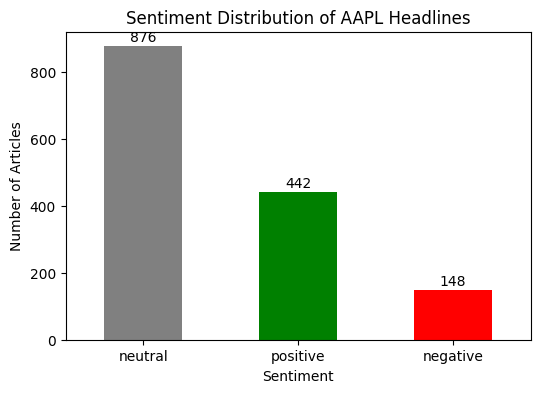

In [44]:
plot_sentiment(sentiment_counts, "AAPL ")

In [45]:
relevant_columns = ['headline', 'polarity', 'Close', 'Daily Returns']

In [46]:
aapl_related_data['Daily Returns'] = aapl_related_data['Close'].pct_change()

In [47]:
aapl_related_data.columns

Index(['headline', 'url', 'publisher', 'stock', 'time', 'hour', 'minute',
       'year', 'month', 'day', 'day_of_week', 'headlineClean',
       'publisher_domain', 'headline_length', 'Open', 'High', 'Low', 'Close',
       'Adj Close', 'Volume', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_signal',
       'MACD_hist', 'sentiment', 'polarity', 'Daily Returns'],
      dtype='object')

In [48]:
aapl_related_data[relevant_columns].head()

headline  polarity  \
Date                                                                      
2009-08-27    China Unicom(CHU) to Launch Apple (AAPL) Iphone       0.0   
2011-06-23                At Least We Still Have Apple (AAPL)      -0.3   
2011-01-11  Tuesday's Mid-Day Options Volume Leaders (BAC,...       0.0   
2011-01-10  Monday's Mid-Day Options Volume Leaders (C, AA...       0.0   
2011-01-07  Earnings For The S&P 500 Expected To Be Highes...       0.0   

                Close  Daily Returns  
Date                                  
2009-08-27   6.051786            NaN  
2011-06-23  11.829643       0.954736  
2011-01-11  12.201429       0.031428  
2011-01-10  12.230357       0.002371  
2011-01-07  12.004286      -0.018484

Correlation

In [49]:
correlation = aapl_related_data['polarity'].corr(aapl_related_data['Daily Returns'])
print("Correlation between sentiment and daily stock returns:", correlation)

Correlation between sentiment and daily stock returns: 0.20959787528455046


In [50]:
correlation = aapl_related_data['polarity'].corr(aapl_related_data['Close'])
print("Correlation between sentiment and closing:", correlation)

Correlation between sentiment and closing: 0.23058497088814925


Get AMAZON companies stock dataset

In [51]:
# Access the AMZN dataset
amzn_df = processed_data["AMZN"]

# Display the first 5 rows of the AMZN dataset
amzn_df.head()

Date      Open      High       Low     Close  Adj Close      Volume  \
0 1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000   
1 1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000   
2 1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000   
3 1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000   
4 1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000   

   SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
0     NaN     NaN  NaN   NaN          NaN        NaN  
1     NaN     NaN  NaN   NaN          NaN        NaN  
2     NaN     NaN  NaN   NaN          NaN        NaN  
3     NaN     NaN  NaN   NaN          NaN        NaN  
4     NaN     NaN  NaN   NaN          NaN        NaN

In [52]:
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6846 entries, 0 to 6845
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6846 non-null   datetime64[ns]
 1   Open         6846 non-null   float64       
 2   High         6846 non-null   float64       
 3   Low          6846 non-null   float64       
 4   Close        6846 non-null   float64       
 5   Adj Close    6846 non-null   float64       
 6   Volume       6846 non-null   int64         
 7   SMA_50       6797 non-null   float64       
 8   EMA_50       6797 non-null   float64       
 9   RSI          6832 non-null   float64       
 10  MACD         6813 non-null   float64       
 11  MACD_signal  6813 non-null   float64       
 12  MACD_hist    6813 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 695.4 KB


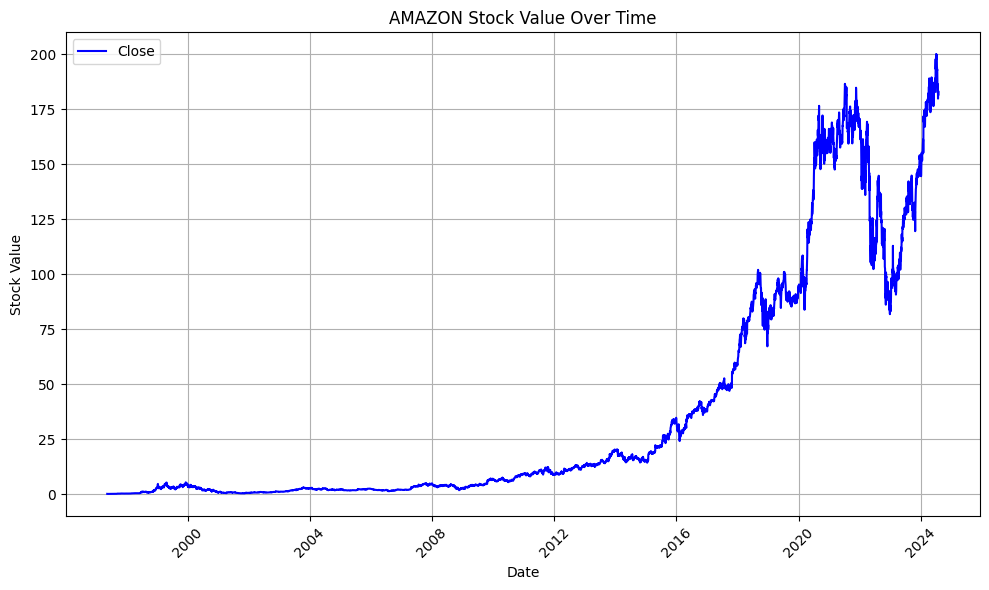

In [53]:
# Plot stock values for each company
plot_stock_data(amzn_df, date_column='Date', stock_value_column='Close', title=f'AMAZON Stock Value Over Time')

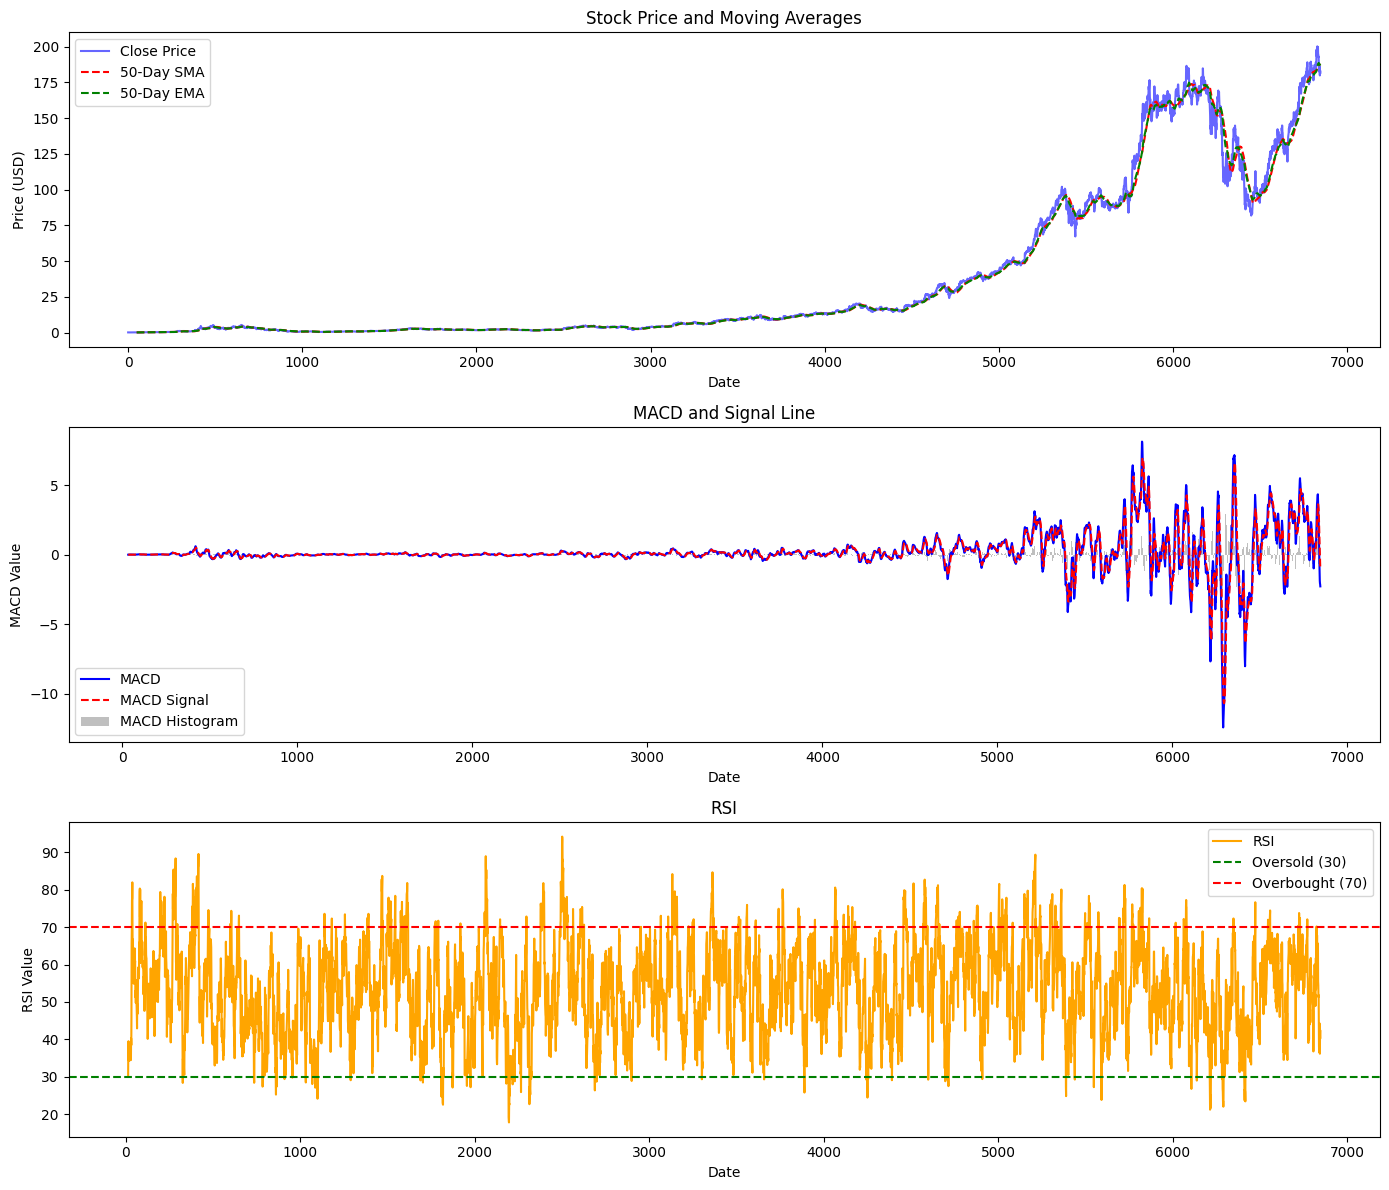

In [54]:
analyze_stock_data(amzn_df)

In [55]:
amzn_df.head()

Date      Open      High       Low     Close  Adj Close      Volume  \
0 1997-05-15  0.121875  0.125000  0.096354  0.097917   0.097917  1443120000   
1 1997-05-16  0.098438  0.098958  0.085417  0.086458   0.086458   294000000   
2 1997-05-19  0.088021  0.088542  0.081250  0.085417   0.085417   122136000   
3 1997-05-20  0.086458  0.087500  0.081771  0.081771   0.081771   109344000   
4 1997-05-21  0.081771  0.082292  0.068750  0.071354   0.071354   377064000   

   SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
0     NaN     NaN  NaN   NaN          NaN        NaN  
1     NaN     NaN  NaN   NaN          NaN        NaN  
2     NaN     NaN  NaN   NaN          NaN        NaN  
3     NaN     NaN  NaN   NaN          NaN        NaN  
4     NaN     NaN  NaN   NaN          NaN        NaN

In [56]:
# Ensure 'Date' column is in datetime format
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'], errors='coerce')

# Set 'Date' as the index
amzn_df.set_index('Date', inplace=True)

Merge AMZN with rating dataset

In [57]:
amzn_merged_data = pd.merge(text_data, amzn_df, left_on='Date', right_index=True, how='inner')


In [58]:
amzn_merged_data.head()

headline  \
Date                                                            
2020-06-05            Stocks That Hit 52-Week Highs On Friday   
2020-06-03         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26                      71 Biggest Movers From Friday   
2020-05-22       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22  B of A Securities Maintains Neutral on Agilent...   

                                                          url  \
Date                                                            
2020-06-05  https://www.benzinga.com/news/20/06/16190091/s...   
2020-06-03  https://www.benzinga.com/news/20/06/16170189/s...   
2020-05-26  https://www.benzinga.com/news/20/05/16103463/7...   
2020-05-22  https://www.benzinga.com/news/20/05/16095921/4...   
2020-05-22  https://www.benzinga.com/news/20/05/16095304/b...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-06-05  Benzinga Insights     A  10:30:54    10      30  2020      6    5   
2020-06-03  Benzinga Insights     A  10:45:20    10      45  2020      6    3   
2020-05-26         Lisa Levin     A  04:30:07     4      30  2020      5   26   
2020-05-22         Lisa Levin     A  12:45:06    12      45  2020      5   22   
2020-05-22         Vick Meyer     A  11:38:59    11      38  2020      5   22   

            ...         Low       Close   Adj Close    Volume     SMA_50  \
Date        ...                                                            
2020-06-05  ...  121.856499  124.150002  124.150002  66128000  114.82120   
2020-06-03  ...  123.058502  123.919998  123.919998  53420000  113.70354   
2020-05-26  ...  120.703003  121.093002  121.093002  71364000  109.98467   
2020-05-22  ...  121.506500  121.844002  121.844002  57342000  109.34781   
2020-05-22  ...  121.506500  121.844002  121.844002  57342000  109.34781   

                EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                 
2020-06-05  115.461894  61.677942  2.338219     2.579951  -0.241731  
2020-06-03  114.783901  62.138294  2.454278     2.711942  -0.257663  
2020-05-26  112.719297  57.409614  2.996401     3.366304  -0.369903  
2020-05-22  112.377513  59.157753  3.209190     3.458780  -0.249590  
2020-05-22  112.377513  59.157753  3.209190     3.458780  -0.249590  

[5 rows x 26 columns]

In [59]:
# Filter rows where 'headline' contains "AMZN"
amzn_related_data = amzn_merged_data[amzn_merged_data['headline'].str.contains("AMZN", case=False, na=False)]

# Display the filtered DataFrame
amzn_related_data

headline  \
Date                                                            
2009-12-21  Holiday Party May Be Starting As Alcoa Inc (NY...   
2009-10-07           Fast Money Guys Like RTP, LAZ, AMZN, DFS   
2017-10-26  DrugChannels' Adam Fein Recently Tweets 'Scoop...   
2017-06-08  Amazon (AMZN) to Come Up with New Facility in ...   
2009-12-30  US Markets Shed Gains For The Second Consecuti...   
...                                                       ...   
2011-05-02  CEOWORLD Top Stocks Picks to Watch 5/2/11- DAN...   
2011-04-28  Stocks we are watching on 4/28- AMZN, LVLT, NF...   
2011-04-26  CEOWORLD Stocks Picks to Watch on 4/26/11 – NF...   
2019-12-31  Benzinga Pro's Top 5 Stocks To Watch For Tues....   
2015-08-17  Quartz's Shelly Banjo Tweets: 'With purchase o...   

                                                          url  \
Date                                                            
2009-12-21  https://www.benzinga.com/general/69244/holiday...   
2009-10-07  https://www.benzinga.com/media/cnbc/21872/fast...   
2017-10-26  https://www.benzinga.com/news/17/10/10235843/d...   
2017-06-08  https://www.benzinga.com/17/06/9583775/amazon-...   
2009-12-30  https://www.benzinga.com/market-update/73668/u...   
...                                                       ...   
2011-05-02  https://www.benzinga.com/11/05/1047825/ceoworl...   
2011-04-28  https://www.benzinga.com/11/04/1040457/stocks-...   
2011-04-26  https://www.benzinga.com/11/04/1032387/ceoworl...   
2019-12-31  https://www.benzinga.com/pre-market-outlook/19...   
2015-08-17  https://www.benzinga.com/news/15/08/5770183/qu...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2009-12-21   inthemoneystocks    AA  00:00:00     0       0  2009     12   21   
2009-10-07        Craig Jones    AA  00:00:00     0       0  2009     10    7   
2017-10-26      Paul Quintaro   ABC  00:00:00     0       0  2017     10   26   
2017-06-08              Zacks  ABTL  00:00:00     0       0  2017      6    8   
2009-12-30      Monica Gerson   ABX  00:00:00     0       0  2009     12   30   
...                       ...   ...       ...   ...     ...   ...    ...  ...   
2011-05-02          CEO World  YRCW  00:00:00     0       0  2011      5    2   
2011-04-28          CEO World  YRCW  00:00:00     0       0  2011      4   28   
2011-04-26          CEO World  YRCW  00:00:00     0       0  2011      4   26   
2019-12-31  Benzinga Newsdesk  ZNGA  00:00:00     0       0  2019     12   31   
2015-08-17      Paul Quintaro    ZU  00:00:00     0       0  2015      8   17   

            ...        Low      Close  Adj Close     Volume    SMA_50  \
Date        ...                                                         
2009-12-21  ...   6.509500   6.639500   6.639500  189472000   6.16054   
2009-10-07  ...   4.557500   4.698500   4.698500  148902000   4.29791   
2017-10-26  ...  48.427502  48.621498  48.621498  112374000  48.62182   
2017-06-08  ...  50.305500  50.513500  50.513500   55358000  46.99672   
2009-12-30  ...   6.764000   6.824500   6.824500  138264000   6.41501   
...         ...        ...        ...        ...        ...       ...   
2011-05-02  ...   9.809000  10.059500  10.059500  187962000   8.84709   
2011-04-28  ...   9.613500   9.753500   9.753500  146000000   8.82447   
2011-04-26  ...   9.037000   9.115000   9.115000  224000000   8.81222   
2019-12-31  ...  91.611504  92.391998  92.391998   50130000  88.93922   
2015-08-17  ...  26.356001  26.761000  26.761000   51634000  23.72235   

               EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                
2009-12-21   6.151683  55.095184  0.072095     0.148398  -0.076303  
2009-10-07   4.342401  62.868703  0.097134     0.099364  -0.002230  
2017-10-26  48.919007  45.787506  0.057364     0.197410  -0.140046  
2017-06-08  

In [60]:
sentiment_analysis_parallel(amzn_related_data, 'headlineClean')

[('neutral', 0.0), ('positive', 0.2), ('neutral', 0.0), ('positive', 0.13636363636363635), ('neutral', 0.0)]


headline  \
Date                                                            
2009-12-21  Holiday Party May Be Starting As Alcoa Inc (NY...   
2009-10-07           Fast Money Guys Like RTP, LAZ, AMZN, DFS   
2017-10-26  DrugChannels' Adam Fein Recently Tweets 'Scoop...   
2017-06-08  Amazon (AMZN) to Come Up with New Facility in ...   
2009-12-30  US Markets Shed Gains For The Second Consecuti...   
...                                                       ...   
2011-05-02  CEOWORLD Top Stocks Picks to Watch 5/2/11- DAN...   
2011-04-28  Stocks we are watching on 4/28- AMZN, LVLT, NF...   
2011-04-26  CEOWORLD Stocks Picks to Watch on 4/26/11 – NF...   
2019-12-31  Benzinga Pro's Top 5 Stocks To Watch For Tues....   
2015-08-17  Quartz's Shelly Banjo Tweets: 'With purchase o...   

                                                          url  \
Date                                                            
2009-12-21  https://www.benzinga.com/general/69244/holiday...   
2009-10-07  https://www.benzinga.com/media/cnbc/21872/fast...   
2017-10-26  https://www.benzinga.com/news/17/10/10235843/d...   
2017-06-08  https://www.benzinga.com/17/06/9583775/amazon-...   
2009-12-30  https://www.benzinga.com/market-update/73668/u...   
...                                                       ...   
2011-05-02  https://www.benzinga.com/11/05/1047825/ceoworl...   
2011-04-28  https://www.benzinga.com/11/04/1040457/stocks-...   
2011-04-26  https://www.benzinga.com/11/04/1032387/ceoworl...   
2019-12-31  https://www.benzinga.com/pre-market-outlook/19...   
2015-08-17  https://www.benzinga.com/news/15/08/5770183/qu...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2009-12-21   inthemoneystocks    AA  00:00:00     0       0  2009     12   21   
2009-10-07        Craig Jones    AA  00:00:00     0       0  2009     10    7   
2017-10-26      Paul Quintaro   ABC  00:00:00     0       0  2017     10   26   
2017-06-08              Zacks  ABTL  00:00:00     0       0  2017      6    8   
2009-12-30      Monica Gerson   ABX  00:00:00     0       0  2009     12   30   
...                       ...   ...       ...   ...     ...   ...    ...  ...   
2011-05-02          CEO World  YRCW  00:00:00     0       0  2011      5    2   
2011-04-28          CEO World  YRCW  00:00:00     0       0  2011      4   28   
2011-04-26          CEO World  YRCW  00:00:00     0       0  2011      4   26   
2019-12-31  Benzinga Newsdesk  ZNGA  00:00:00     0       0  2019     12   31   
2015-08-17      Paul Quintaro    ZU  00:00:00     0       0  2015      8   17   

            ...  Adj Close     Volume    SMA_50     EMA_50        RSI  \
Date        ...                                                         
2009-12-21  ...   6.639500  189472000   6.16054   6.151683  55.095184   
2009-10-07  ...   4.698500  148902000   4.29791   4.342401  62.868703   
2017-10-26  ...  48.621498  112374000  48.62182  48.919007  45.787506   
2017-06-08  ...  50.513500   55358000  46.99672  47.244648  73.091479   
2009-12-30  ...   6.824500  138264000   6.41501   6.309004  57.117114   
...         ...        ...        ...       ...        ...        ...   
2011-05-02  ...  10.059500  187962000   8.84709   9.036448  72.760752   
2011-04-28  ...   9.753500  146000000   8.82447   8.962209  67.954688   
2011-04-26  ...   9.115000  224000000   8.81222   8.893112  55.145836   
2019-12-31  ...  92.391998   50130000  88.93922  89.315419  64.692442   
2015-08-17  ...  26.761000   51634000  23.72235  24.268803  70.323731   

                MACD  MACD_signal  MACD_hist  sentiment  polarity  
Date                                                               
2009-12-21  0.072095     0.148398  -0.076303    neutral  0.000000  
2009-10-07  0.097134     0.099364  -0.002230   positive  0.200000  
2017-10-26  0.057364     0.197410  -0.140046    neutral  0.000000  
2017-06-08  1.064

In [61]:
sentiment_counts = amzn_related_data['sentiment'].value_counts()

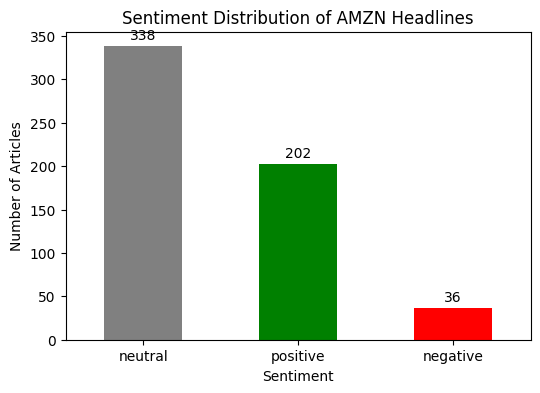

In [62]:
plot_sentiment(sentiment_counts, 'AMZN ')

In [63]:
amzn_related_data['Daily Returns'] = amzn_related_data['Close'].pct_change()

In [64]:
amzn_related_data[relevant_columns].head()

headline  polarity  \
Date                                                                      
2009-12-21  Holiday Party May Be Starting As Alcoa Inc (NY...  0.000000   
2009-10-07           Fast Money Guys Like RTP, LAZ, AMZN, DFS  0.200000   
2017-10-26  DrugChannels' Adam Fein Recently Tweets 'Scoop...  0.000000   
2017-06-08  Amazon (AMZN) to Come Up with New Facility in ...  0.136364   
2009-12-30  US Markets Shed Gains For The Second Consecuti...  0.000000   

                Close  Daily Returns  
Date                                  
2009-12-21   6.639500            NaN  
2009-10-07   4.698500      -0.292341  
2017-10-26  48.621498       9.348302  
2017-06-08  50.513500       0.038913  
2009-12-30   6.824500      -0.864898

Correlation

In [65]:
correlation = amzn_related_data['polarity'].corr(amzn_related_data['Daily Returns'])
print("Correlation between sentiment and daily stock returns:", correlation)

Correlation between sentiment and daily stock returns: 0.06127622642603291


In [66]:
correlation = amzn_related_data['polarity'].corr(amzn_related_data['Close'])
print("Correlation between sentiment and closing:", correlation)

Correlation between sentiment and closing: 0.0545531764801243


Get GOOGLE companies stock dataset

In [67]:
# Access the GOOG dataset
goog_df = processed_data["GOOG"]

# Display the first 5 rows of the GOOG dataset
goog_df.head()

Date      Open      High       Low     Close  Adj Close     Volume  \
0 2004-08-19  2.490664  2.591785  2.390042  2.499133   2.496292  897427216   
1 2004-08-20  2.515820  2.716817  2.503118  2.697639   2.694573  458857488   
2 2004-08-23  2.758411  2.826406  2.716070  2.724787   2.721690  366857939   
3 2004-08-24  2.770615  2.779581  2.579581  2.611960   2.608991  306396159   
4 2004-08-25  2.614201  2.689918  2.587302  2.640104   2.637103  184645512   

   SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
0     NaN     NaN  NaN   NaN          NaN        NaN  
1     NaN     NaN  NaN   NaN          NaN        NaN  
2     NaN     NaN  NaN   NaN          NaN        NaN  
3     NaN     NaN  NaN   NaN          NaN        NaN  
4     NaN     NaN  NaN   NaN          NaN        NaN

In [68]:
goog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5020 non-null   datetime64[ns]
 1   Open         5020 non-null   float64       
 2   High         5020 non-null   float64       
 3   Low          5020 non-null   float64       
 4   Close        5020 non-null   float64       
 5   Adj Close    5020 non-null   float64       
 6   Volume       5020 non-null   int64         
 7   SMA_50       4971 non-null   float64       
 8   EMA_50       4971 non-null   float64       
 9   RSI          5006 non-null   float64       
 10  MACD         4987 non-null   float64       
 11  MACD_signal  4987 non-null   float64       
 12  MACD_hist    4987 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 510.0 KB


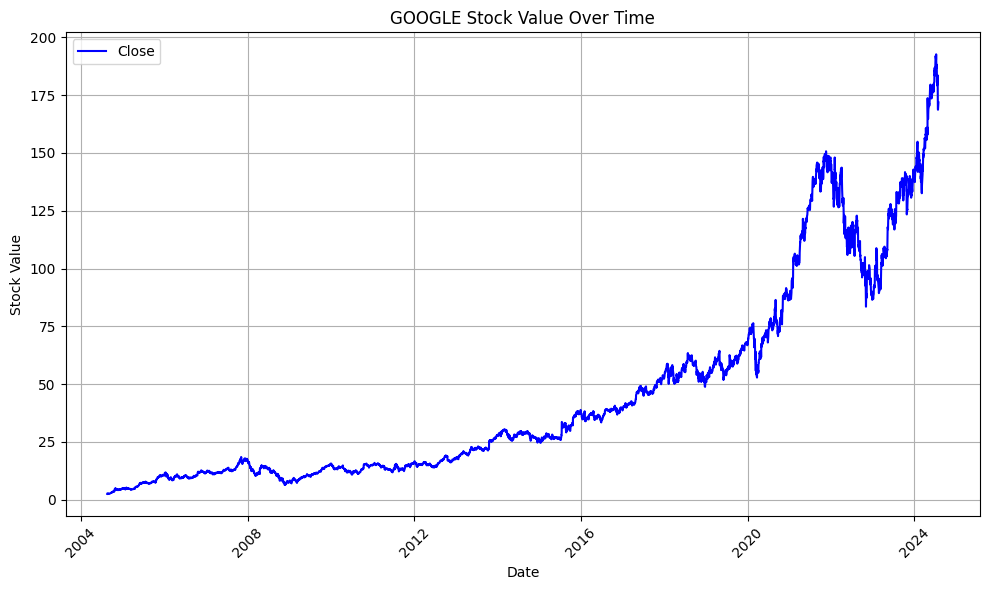

In [69]:
# Plot stock values for each company
plot_stock_data(goog_df, date_column='Date', stock_value_column='Close', title=f'GOOGLE Stock Value Over Time')

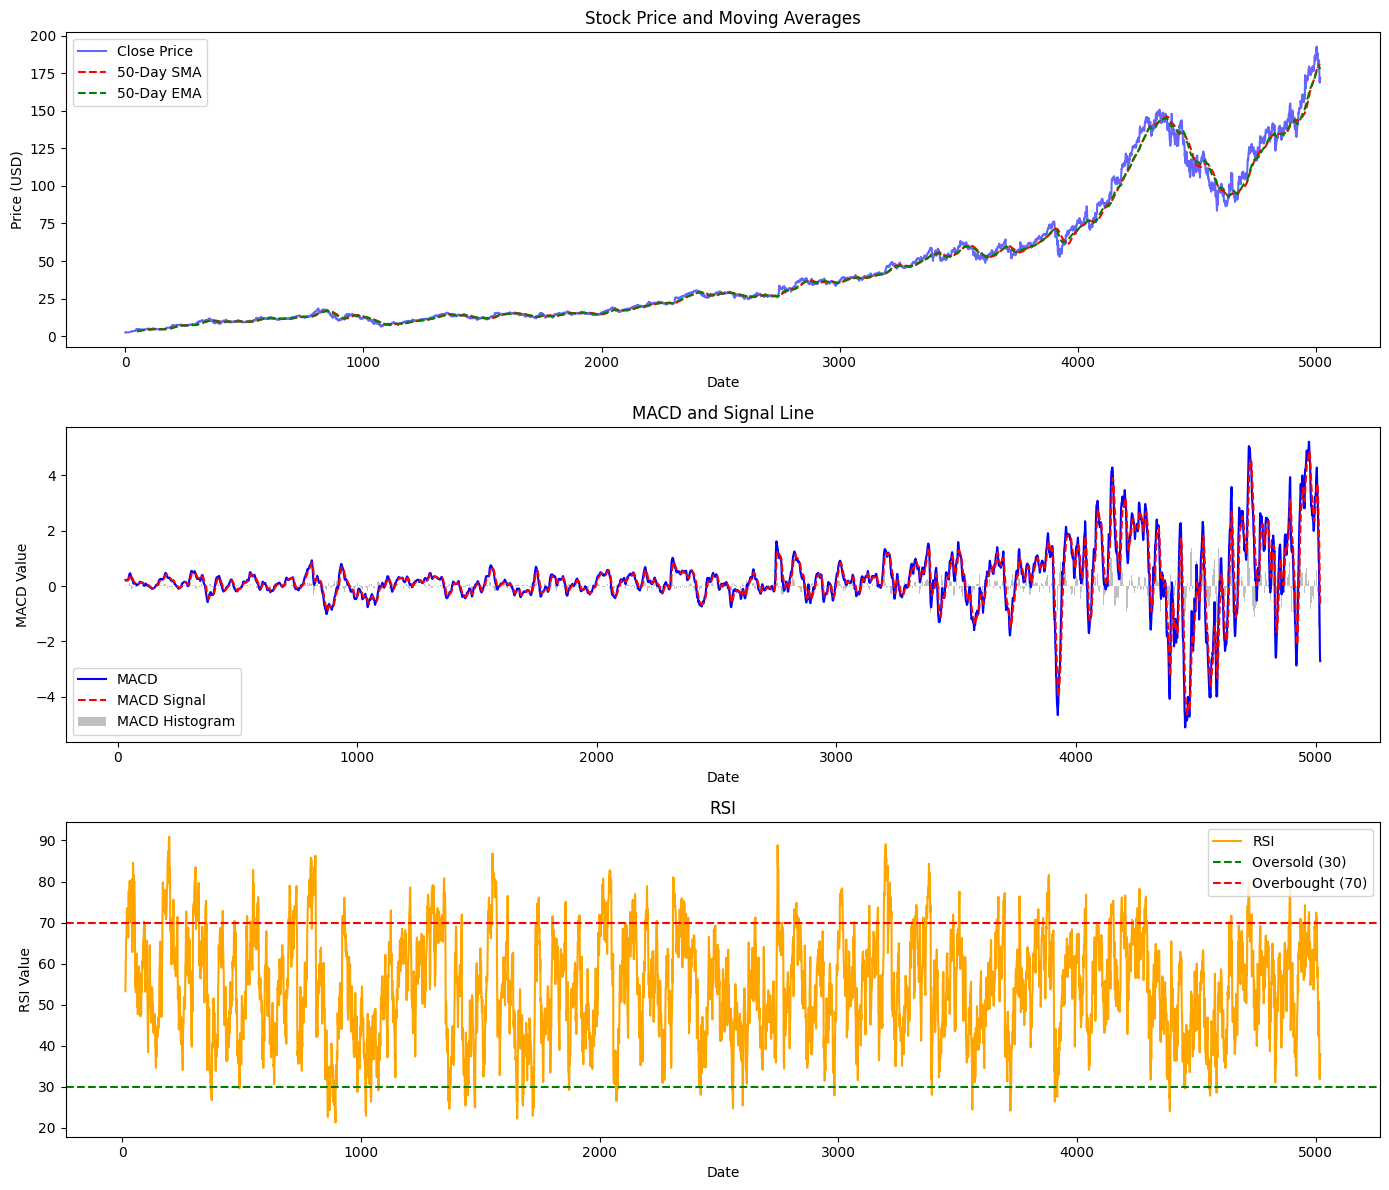

In [70]:
analyze_stock_data(goog_df)

In [71]:
# Ensure 'Date' column is in datetime format
goog_df['Date'] = pd.to_datetime(goog_df['Date'], errors='coerce')

# Set 'Date' as the index
goog_df.set_index('Date', inplace=True)

In [72]:
goog_df.head()

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2004-08-19  2.490664  2.591785  2.390042  2.499133   2.496292  897427216   
2004-08-20  2.515820  2.716817  2.503118  2.697639   2.694573  458857488   
2004-08-23  2.758411  2.826406  2.716070  2.724787   2.721690  366857939   
2004-08-24  2.770615  2.779581  2.579581  2.611960   2.608991  306396159   
2004-08-25  2.614201  2.689918  2.587302  2.640104   2.637103  184645512   

            SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
Date                                                           
2004-08-19     NaN     NaN  NaN   NaN          NaN        NaN  
2004-08-20     NaN     NaN  NaN   NaN          NaN        NaN  
2004-08-23     NaN     NaN  NaN   NaN          NaN        NaN  
2004-08-24     NaN     NaN  NaN   NaN          NaN        NaN  
2004-08-25     NaN     NaN  NaN   NaN          NaN        NaN

Merge GOOG with rating dataset

In [73]:
goog_merged_data = pd.merge(text_data, goog_df, left_on='Date', right_index=True, how='inner')

In [74]:
goog_merged_data.head()

headline  \
Date                                                            
2020-06-05            Stocks That Hit 52-Week Highs On Friday   
2020-06-03         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26                      71 Biggest Movers From Friday   
2020-05-22       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22  B of A Securities Maintains Neutral on Agilent...   

                                                          url  \
Date                                                            
2020-06-05  https://www.benzinga.com/news/20/06/16190091/s...   
2020-06-03  https://www.benzinga.com/news/20/06/16170189/s...   
2020-05-26  https://www.benzinga.com/news/20/05/16103463/7...   
2020-05-22  https://www.benzinga.com/news/20/05/16095921/4...   
2020-05-22  https://www.benzinga.com/news/20/05/16095304/b...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-06-05  Benzinga Insights     A  10:30:54    10      30  2020      6    5   
2020-06-03  Benzinga Insights     A  10:45:20    10      45  2020      6    3   
2020-05-26         Lisa Levin     A  04:30:07     4      30  2020      5   26   
2020-05-22         Lisa Levin     A  12:45:06    12      45  2020      5   22   
2020-05-22         Vick Meyer     A  11:38:59    11      38  2020      5   22   

            ...        Low      Close  Adj Close    Volume     SMA_50  \
Date        ...                                                         
2020-06-05  ...  70.300003  71.919502  71.837753  34698000  65.279305   
2020-06-03  ...  71.488853  71.819000  71.737366  25124000  64.665685   
2020-05-26  ...  70.606499  70.850998  70.770462  41212000  62.639935   
2020-05-22  ...  69.591499  70.521004  70.440842  26188000  62.442645   
2020-05-22  ...  69.591499  70.521004  70.440842  26188000  62.442645   

               EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                
2020-06-05  67.408455  63.793213  1.659807     1.782164  -0.122357  
2020-06-03  67.086181  66.602102  1.824630     1.844852  -0.020222  
2020-05-26  65.901975  64.260484  1.882794     1.837785   0.045009  
2020-05-22  65.699974  63.383755  1.864227     1.826533   0.037695  
2020-05-22  65.699974  63.383755  1.864227     1.826533   0.037695  

[5 rows x 26 columns]

In [75]:
# Filter rows where 'headline' contains "GOOG"
goog_related_data = goog_merged_data[goog_merged_data['headline'].str.contains("GOOG", case=False, na=False)]

# Display the filtered DataFrame
goog_related_data

headline  \
Date                                                            
2010-02-17  The Google Buzz Guide for the Enterprise (with...   
2009-09-04  Develop Privacy Policy for Google (GOOG) Books...   
2011-04-12                        Zings Of The Day (AA, GOOG)   
2010-10-11  Week in Preview: Earnings Expectations for Int...   
2010-07-07  Doug Kass Looking Like A Genius Again (DJI, JP...   
...                                                       ...   
2012-02-09  If Facebook Is Worth $100 Billion, Google Look...   
2012-01-30  The Facebook IPO: Google All Over Again, and a...   
2012-01-10         Will Investors Buy into Google's Weakness?   
2015-03-27  Porat To Google Just One Of The Week's Top Man...   
2018-10-08  The Week Ahead: Google Unveils New Pixel Phone...   

                                                          url       publisher  \
Date                                                                            
2010-02-17  https://www.benzinga.com/146954/the-google-buz...   Mark Fidelman   
2009-09-04  https://www.benzinga.com/benzingastaff1/2009/9...  BenzingaStaff1   
2011-04-12  https://www.benzinga.com/news/11/04/998370/zin...   Roger Nachman   
2010-10-11  https://www.benzinga.com/news/10/10/517483/wee...  Benzinga Staff   
2010-07-07  https://www.benzinga.com/media/cnbc/10/07/3653...    Swing Trader   
...                                                       ...             ...   
2012-02-09  https://www.benzinga.com/general/movers-shaker...     Minyanville   
2012-01-30  https://www.benzinga.com/general/movers-shaker...     Minyanville   
2012-01-10  https://www.benzinga.com/tech/12/01/2252140/wi...  Louis Bedigian   
2015-03-27  https://www.benzinga.com/news/15/03/5364053/po...   Monica Gerson   
2018-10-08  https://www.benzinga.com/general/biotech/18/10...      Taylor Cox   

           stock      time  hour  minute  year  month  day  ...        Low  \
Date                                                        ...              
2010-02-17     A  00:00:00     0       0  2010      2   17  ...  13.390061   
2009-09-04     A  00:00:00     0       0  2009      9    4  ...  11.351950   
2011-04-12    AA  00:00:00     0       0  2011      4   12  ...  14.148219   
2010-10-11    AA  00:00:00     0       0  2010     10   11  ...  13.379102   
2010-07-07    AA  00:00:00     0       0  2010      7    7  ...  10.843855   
...          ...       ...   ...     ...   ...    ...  ...  ...        ...   
2012-02-09  ZNGA  00:00:00     0       0  2012      2    9  ...  15.168146   
2012-01-30  ZNGA  00:00:00     0       0  2012      1   30  ...  14.281470   
2012-01-10  ZNGA  00:00:00     0       0  2012      1   10  ...  15.365158   
2015-03-27   ZQK  00:00:00     0       0  2015      3   27  ...  27.331461   
2018-10-08  ZUMZ  00:00:00     0       0  2018     10    8  ...  56.368198   

                Close  Adj Close     Volume     SMA_50     EMA_50        RSI  \
Date                                                                           
2010-02-17  13.405005  13.389769   81492313  14.361724  13.935633  40.756581   
2009-09-04  11.489435  11.476376   60192775  11.016393  11.068980  56.108004   
2011-04-12  14.211980  14.195826   83736694  14.814805  14.658539  41.371851   
2010-10-11  13.420696  13.405441  105445761  12.281899  12.485667  70.165643   
2010-07-07  11.212971  11.200226  125657235  12.195937  12.205048  36.405247   
...               ...        ...        ...        ...        ...        ...   
2012-02-09  15.229416  15.212105   90927546  15.369217  15.089267  53.842248   
2012-01-30  14.388319  14.371964   93569411  15.324341  15.157778  35.381099   
2012-01-10  15.520326  15.502685  176483032  15.311962  15.322566  46.474590   
2015-03-27  27.341932  27.310854   37949906  27.079403  27.286553  46.612436   
2018-10-08  57.448502  57.383202   38648000  60.040700  59.240653  37.573582   

                MACD  MACD_signal  MACD_hist  
Date                                          
201

In [76]:
sentiment_analysis_parallel(goog_related_data, 'headlineClean')

[('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0)]


headline  \
Date                                                            
2010-02-17  The Google Buzz Guide for the Enterprise (with...   
2009-09-04  Develop Privacy Policy for Google (GOOG) Books...   
2011-04-12                        Zings Of The Day (AA, GOOG)   
2010-10-11  Week in Preview: Earnings Expectations for Int...   
2010-07-07  Doug Kass Looking Like A Genius Again (DJI, JP...   
...                                                       ...   
2012-02-09  If Facebook Is Worth $100 Billion, Google Look...   
2012-01-30  The Facebook IPO: Google All Over Again, and a...   
2012-01-10         Will Investors Buy into Google's Weakness?   
2015-03-27  Porat To Google Just One Of The Week's Top Man...   
2018-10-08  The Week Ahead: Google Unveils New Pixel Phone...   

                                                          url       publisher  \
Date                                                                            
2010-02-17  https://www.benzinga.com/146954/the-google-buz...   Mark Fidelman   
2009-09-04  https://www.benzinga.com/benzingastaff1/2009/9...  BenzingaStaff1   
2011-04-12  https://www.benzinga.com/news/11/04/998370/zin...   Roger Nachman   
2010-10-11  https://www.benzinga.com/news/10/10/517483/wee...  Benzinga Staff   
2010-07-07  https://www.benzinga.com/media/cnbc/10/07/3653...    Swing Trader   
...                                                       ...             ...   
2012-02-09  https://www.benzinga.com/general/movers-shaker...     Minyanville   
2012-01-30  https://www.benzinga.com/general/movers-shaker...     Minyanville   
2012-01-10  https://www.benzinga.com/tech/12/01/2252140/wi...  Louis Bedigian   
2015-03-27  https://www.benzinga.com/news/15/03/5364053/po...   Monica Gerson   
2018-10-08  https://www.benzinga.com/general/biotech/18/10...      Taylor Cox   

           stock      time  hour  minute  year  month  day  ...  Adj Close  \
Date                                                        ...              
2010-02-17     A  00:00:00     0       0  2010      2   17  ...  13.389769   
2009-09-04     A  00:00:00     0       0  2009      9    4  ...  11.476376   
2011-04-12    AA  00:00:00     0       0  2011      4   12  ...  14.195826   
2010-10-11    AA  00:00:00     0       0  2010     10   11  ...  13.405441   
2010-07-07    AA  00:00:00     0       0  2010      7    7  ...  11.200226   
...          ...       ...   ...     ...   ...    ...  ...  ...        ...   
2012-02-09  ZNGA  00:00:00     0       0  2012      2    9  ...  15.212105   
2012-01-30  ZNGA  00:00:00     0       0  2012      1   30  ...  14.371964   
2012-01-10  ZNGA  00:00:00     0       0  2012      1   10  ...  15.502685   
2015-03-27   ZQK  00:00:00     0       0  2015      3   27  ...  27.310854   
2018-10-08  ZUMZ  00:00:00     0       0  2018     10    8  ...  57.383202   

               Volume     SMA_50     EMA_50        RSI      MACD  MACD_signal  \
Date                                                                            
2010-02-17   81492313  14.361724  13.935633  40.756581 -0.294550    -0.347101   
2009-09-04   60192775  11.016393  11.068980  56.108004  0.113760     0.153302   
2011-04-12   83736694  14.814805  14.658539  41.371851 -0.106528    -0.117365   
2010-10-11  105445761  12.281899  12.485667  70.165643  0.357812     0.338972   
2010-07-07  125657235  12.195937  12.205048  36.405247 -0.368951    -0.282930   
...               ...        ...        ...        ...       ...          ...   
2012-02-09   90927546  15.369217  15.089267  53.842248 -0.111421    -0.201742   
2012-01-30   93569411  15.324341  15.157778  35.381099 -0.340879    -0.172757   
2012-01-10  176483032  15.311962  15.322566  46.474590  0.214069     0.283691   
2015-03-27   37949906  27.079403  27.286553  46.612436  0.154493     0.246146   
2018-10-08   38648000  60.040700  59.240653  37.573582 -0.327312    -0.243893   

            MACD_hist  sentiment  polarity  
Date                                   

In [77]:
sentiment_counts = goog_related_data['sentiment'].value_counts()

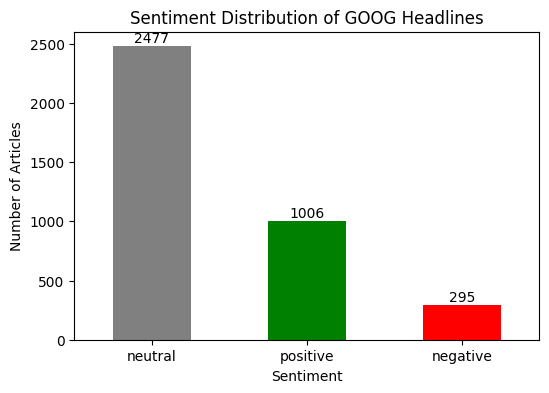

In [78]:
plot_sentiment(sentiment_counts, 'GOOG ')

In [79]:
goog_related_data['Daily Returns'] = goog_related_data['Close'].pct_change()

In [80]:
goog_related_data[relevant_columns].head()

headline  polarity  \
Date                                                                      
2010-02-17  The Google Buzz Guide for the Enterprise (with...       0.0   
2009-09-04  Develop Privacy Policy for Google (GOOG) Books...       0.0   
2011-04-12                        Zings Of The Day (AA, GOOG)       0.0   
2010-10-11  Week in Preview: Earnings Expectations for Int...       0.0   
2010-07-07  Doug Kass Looking Like A Genius Again (DJI, JP...       0.0   

                Close  Daily Returns  
Date                                  
2010-02-17  13.405005            NaN  
2009-09-04  11.489435      -0.142900  
2011-04-12  14.211980       0.236961  
2010-10-11  13.420696      -0.055677  
2010-07-07  11.212971      -0.164502

Correlation

In [81]:
correlation = goog_related_data['polarity'].corr(goog_related_data['Daily Returns'])
print("Correlation between sentiment and daily stock returns:", correlation)

Correlation between sentiment and daily stock returns: 0.023364377761296514


In [82]:
correlation = goog_related_data['polarity'].corr(goog_related_data['Close'])
print("Correlation between sentiment and closing:", correlation)

Correlation between sentiment and closing: -0.022225268990637467


Get META companies stock dataset

In [83]:
# Access the META dataset
meta_df = processed_data["META"]

# Display the first 5 rows of the META dataset
meta_df.head()

Date       Open       High        Low      Close  Adj Close    Volume  \
0 2012-12-12  28.000000  28.139999  27.370001  27.580000  27.523441  46704200   
1 2012-12-13  27.590000  28.750000  27.430000  28.240000  28.182087  81051600   
2 2012-12-14  28.180000  28.330000  26.760000  26.809999  26.755020  91631600   
3 2012-12-17  26.770000  27.000000  26.320000  26.750000  26.695143  57742500   
4 2012-12-18  26.959999  27.910000  26.900000  27.709999  27.653173  60512900   

   SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
0     NaN     NaN  NaN   NaN          NaN        NaN  
1     NaN     NaN  NaN   NaN          NaN        NaN  
2     NaN     NaN  NaN   NaN          NaN        NaN  
3     NaN     NaN  NaN   NaN          NaN        NaN  
4     NaN     NaN  NaN   NaN          NaN        NaN

In [84]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2926 entries, 0 to 2925
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2926 non-null   datetime64[ns]
 1   Open         2926 non-null   float64       
 2   High         2926 non-null   float64       
 3   Low          2926 non-null   float64       
 4   Close        2926 non-null   float64       
 5   Adj Close    2926 non-null   float64       
 6   Volume       2926 non-null   int64         
 7   SMA_50       2877 non-null   float64       
 8   EMA_50       2877 non-null   float64       
 9   RSI          2912 non-null   float64       
 10  MACD         2893 non-null   float64       
 11  MACD_signal  2893 non-null   float64       
 12  MACD_hist    2893 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 297.3 KB


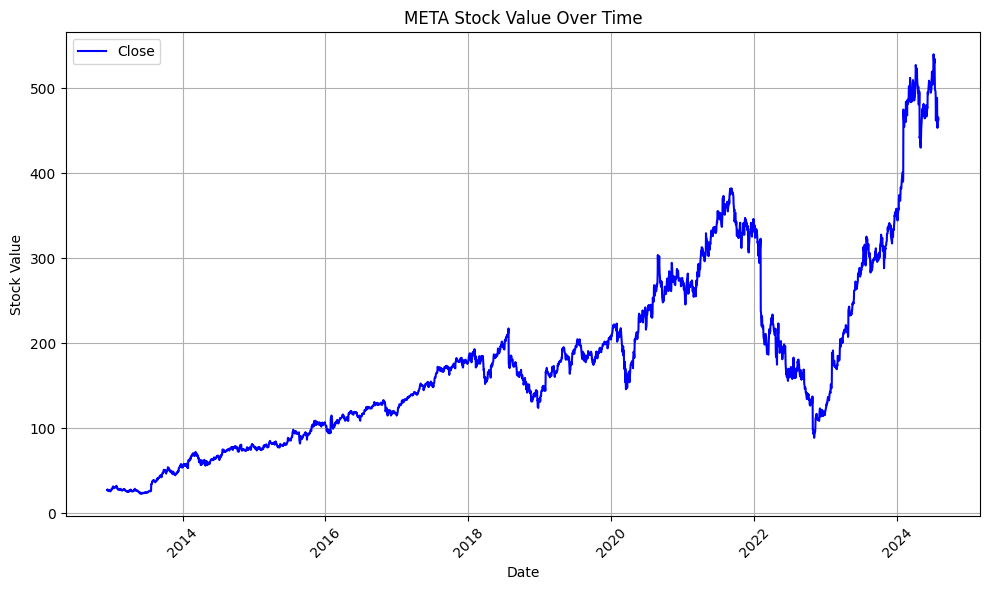

In [85]:
# Plot stock values for each company
plot_stock_data(meta_df, date_column='Date', stock_value_column='Close', title=f'META Stock Value Over Time')

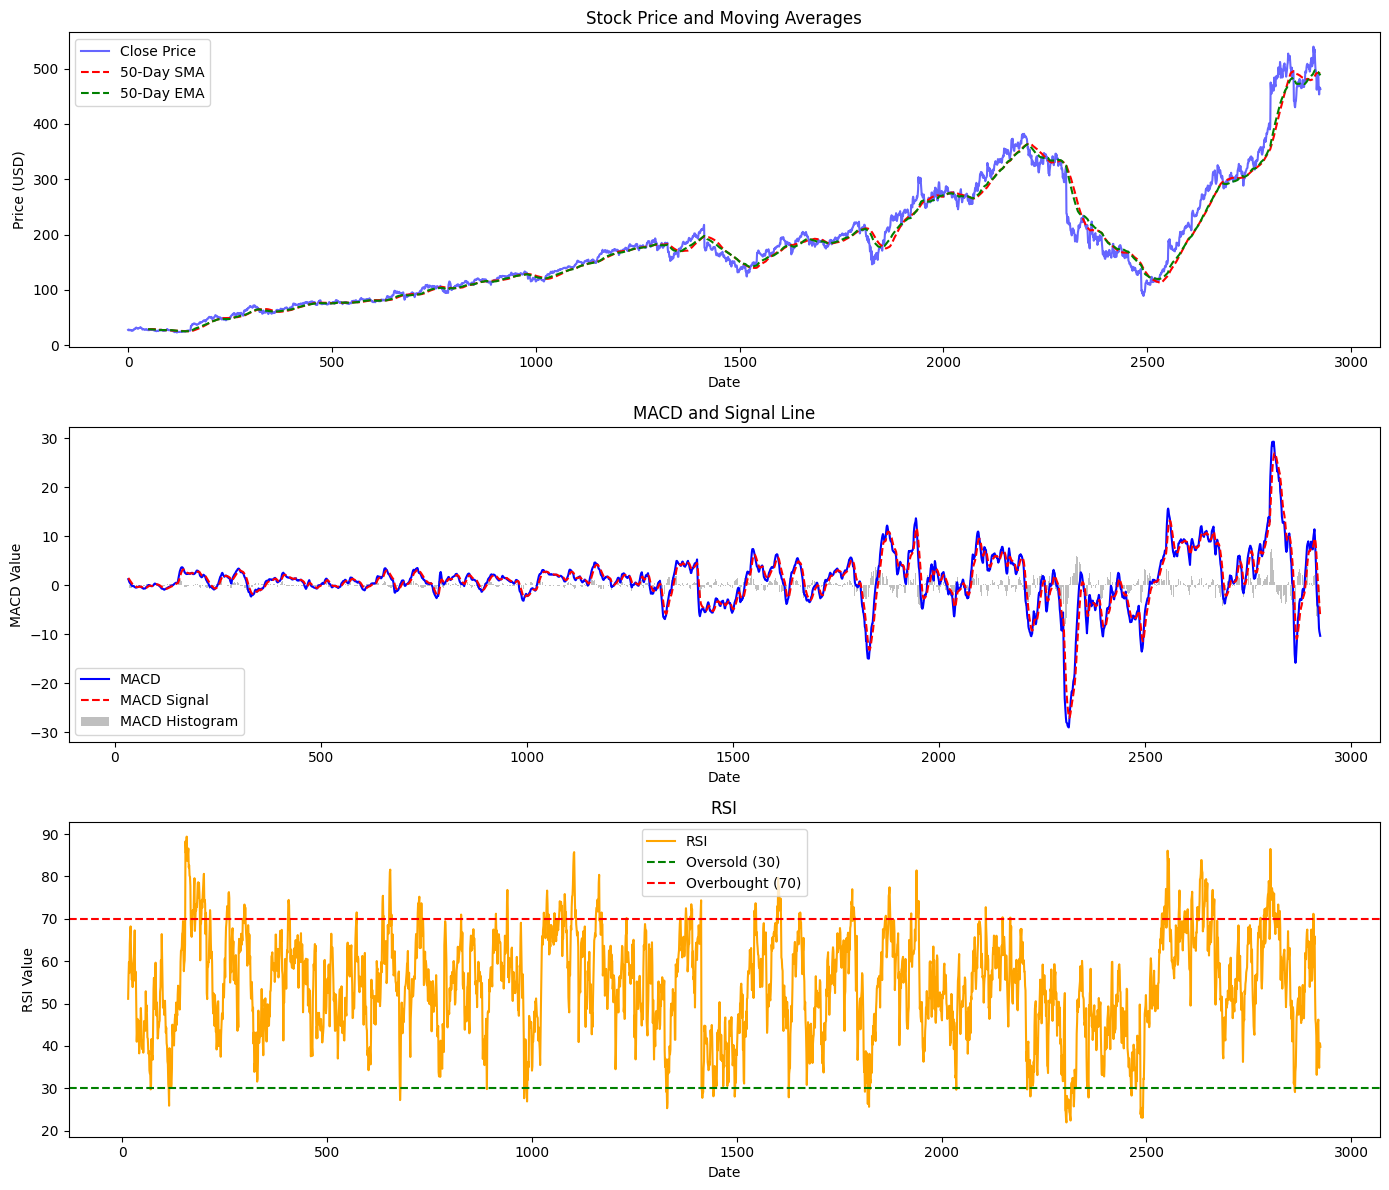

In [86]:
analyze_stock_data(meta_df)

In [87]:
# Ensure 'Date' column is in datetime format
meta_df['Date'] = pd.to_datetime(meta_df['Date'], errors='coerce')

# Set 'Date' as the index
meta_df.set_index('Date', inplace=True)

In [88]:
meta_df.head()

Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2012-12-12  28.000000  28.139999  27.370001  27.580000  27.523441  46704200   
2012-12-13  27.590000  28.750000  27.430000  28.240000  28.182087  81051600   
2012-12-14  28.180000  28.330000  26.760000  26.809999  26.755020  91631600   
2012-12-17  26.770000  27.000000  26.320000  26.750000  26.695143  57742500   
2012-12-18  26.959999  27.910000  26.900000  27.709999  27.653173  60512900   

            SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
Date                                                           
2012-12-12     NaN     NaN  NaN   NaN          NaN        NaN  
2012-12-13     NaN     NaN  NaN   NaN          NaN        NaN  
2012-12-14     NaN     NaN  NaN   NaN          NaN        NaN  
2012-12-17     NaN     NaN  NaN   NaN          NaN        NaN  
2012-12-18     NaN     NaN  NaN   NaN          NaN        NaN

Merge META with rating dataset

In [89]:
meta_merged_data = pd.merge(text_data, meta_df, left_on='Date', right_index=True, how='inner')

In [90]:
meta_merged_data.head()

headline  \
Date                                                            
2020-06-05            Stocks That Hit 52-Week Highs On Friday   
2020-06-03         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26                      71 Biggest Movers From Friday   
2020-05-22       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22  B of A Securities Maintains Neutral on Agilent...   

                                                          url  \
Date                                                            
2020-06-05  https://www.benzinga.com/news/20/06/16190091/s...   
2020-06-03  https://www.benzinga.com/news/20/06/16170189/s...   
2020-05-26  https://www.benzinga.com/news/20/05/16103463/7...   
2020-05-22  https://www.benzinga.com/news/20/05/16095921/4...   
2020-05-22  https://www.benzinga.com/news/20/05/16095304/b...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-06-05  Benzinga Insights     A  10:30:54    10      30  2020      6    5   
2020-06-03  Benzinga Insights     A  10:45:20    10      45  2020      6    3   
2020-05-26         Lisa Levin     A  04:30:07     4      30  2020      5   26   
2020-05-22         Lisa Levin     A  12:45:06    12      45  2020      5   22   
2020-05-22         Vick Meyer     A  11:38:59    11      38  2020      5   22   

            ...         Low       Close   Adj Close    Volume      SMA_50  \
Date        ...                                                             
2020-06-05  ...  225.309998  230.770004  230.296753  16750400  197.055601   
2020-06-03  ...  228.529999  230.160004  229.688019  15380300  194.258201   
2020-05-26  ...  231.669998  232.199997  231.723816  33178300  184.635601   
2020-05-22  ...  228.740005  234.910004  234.428268  33925600  183.397201   
2020-05-22  ...  228.740005  234.910004  234.428268  33925600  183.397201   

                EMA_50        RSI       MACD  MACD_signal  MACD_hist  
Date                                                                  
2020-06-05  206.688350  64.365644   9.226822    10.240398  -1.013577  
2020-06-03  204.865239  65.999901  10.297611    10.727764  -0.430154  
2020-05-26  198.265344  73.749612  12.152690    10.462195   1.690495  
2020-05-22  196.880256  77.433374  11.870212    10.039572   1.830640  
2020-05-22  196.880256  77.433374  11.870212    10.039572   1.830640  

[5 rows x 26 columns]

In [91]:
# Filter rows where 'headline' contains "META"
meta_related_data = meta_merged_data[meta_merged_data['headline'].str.contains("META", case=False, na=False)]

# Display the filtered DataFrame
meta_related_data

headline  \
Date                                                            
2020-05-14  Alcoa CEO, Currently Presenting At BMO Global ...   
2019-05-03  Shares of several consumer metals and mining c...   
2019-04-17  Alcoa To Report Q1 Earnings After The Closing ...   
2018-04-23  Watching Stock Futures Largely Unaffected, But...   
2018-04-06  Watch Shares Of Century Aluminum, Alcoa, Arcon...   
...                                                       ...   
2015-09-30  Zafgen Granted Orphan Drug Designation in the ...   
2015-12-10  ZIOPHARM Reports Presentation of Phase 1b/2 St...   
2015-04-27  ZIOPHARM Begins Phase 1b/2 Study of Ad-RTS-hIL...   
2013-03-26  ZIOPHARM Phase 3 Trial of Palifosfamide for Me...   
2016-12-07  Auto Parts Suppliers Trading Up: China Zenix 9...   

                                                          url  \
Date                                                            
2020-05-14  https://www.benzinga.com/news/20/05/16032673/a...   
2019-05-03  https://www.benzinga.com/markets/wiim/19/05/13...   
2019-04-17  https://www.benzinga.com/news/earnings/19/04/1...   
2018-04-23  https://www.benzinga.com/news/18/04/11556874/w...   
2018-04-06  https://www.benzinga.com/trading-ideas/movers/...   
...                                                       ...   
2015-09-30  https://www.benzinga.com/news/15/09/5875608/za...   
2015-12-10  https://www.benzinga.com/news/15/12/6036319/zi...   
2015-04-27  https://www.benzinga.com/news/15/04/5444728/zi...   
2013-03-26  https://www.benzinga.com/news/13/03/3445978/zi...   
2016-12-07  https://www.benzinga.com/movers/16/12/8781427/...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-05-14  Benzinga Newsdesk    AA  00:00:00     0       0  2020      5   14   
2019-05-03  Benzinga Newsdesk    AA  00:00:00     0       0  2019      5    3   
2019-04-17  Benzinga Newsdesk    AA  00:00:00     0       0  2019      4   17   
2018-04-23      Paul Quintaro    AA  00:00:00     0       0  2018      4   23   
2018-04-06       Eddie Staley    AA  00:00:00     0       0  2018      4    6   
...                       ...   ...       ...   ...     ...   ...    ...  ...   
2015-09-30      Paul Quintaro  ZFGN  00:00:00     0       0  2015      9   30   
2015-12-10         Hal Lindon  ZIOP  00:00:00     0       0  2015     12   10   
2015-04-27         Hal Lindon  ZIOP  00:00:00     0       0  2015      4   27   
2013-03-26      Charles Gross  ZIOP  00:00:00     0       0  2013      3   26   
2016-12-07      Paul Quintaro    ZX  00:00:00     0       0  2016     12    7   

            ...         Low       Close   Adj Close    Volume      SMA_50  \
Date        ...                                                             
2020-05-14  ...  200.690002  206.809998  206.385895  17178900  177.426001   
2019-05-03  ...  193.710007  195.470001  195.069153  14575400  174.059999   
2019-04-17  ...  178.360001  178.779999  178.413376   9973700  168.667999   
2018-04-23  ...  165.089996  165.839996  165.499908  23088100  171.351800   
2018-04-06  ...  156.809998  157.199997  156.877625  41644800  175.780199   
...         ...         ...         ...         ...       ...         ...   
2015-09-30  ...   88.010002   89.900002   89.715637  36169100   92.256400   
2015-12-10  ...  104.410004  105.419998  105.203812  17454300  102.042000   
2015-04-27  ...   81.629997   81.910004   81.742027  25446000   80.997800   
2013-03-26  ...   25.030001   25.209999   25.158300  26957200   28.369600   
2016-12-07  ...  116.570000  117.949997  117.708115  21913700  124.541200   

                EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                 
2020-05-14  189.659873  62.134437  9.167491     8.856400   0.311091  
2019-05-03  175.700819  74.788827  6.303742     5.468564   0.835178  
2019-04-17  167.941250  6

In [92]:
sentiment_analysis_parallel(meta_related_data, 'headlineClean')

[('neutral', 0.0), ('positive', 0.125), ('neutral', 0.0), ('negative', -0.016666666666666666), ('neutral', 0.0)]


headline  \
Date                                                            
2020-05-14  Alcoa CEO, Currently Presenting At BMO Global ...   
2019-05-03  Shares of several consumer metals and mining c...   
2019-04-17  Alcoa To Report Q1 Earnings After The Closing ...   
2018-04-23  Watching Stock Futures Largely Unaffected, But...   
2018-04-06  Watch Shares Of Century Aluminum, Alcoa, Arcon...   
...                                                       ...   
2015-09-30  Zafgen Granted Orphan Drug Designation in the ...   
2015-12-10  ZIOPHARM Reports Presentation of Phase 1b/2 St...   
2015-04-27  ZIOPHARM Begins Phase 1b/2 Study of Ad-RTS-hIL...   
2013-03-26  ZIOPHARM Phase 3 Trial of Palifosfamide for Me...   
2016-12-07  Auto Parts Suppliers Trading Up: China Zenix 9...   

                                                          url  \
Date                                                            
2020-05-14  https://www.benzinga.com/news/20/05/16032673/a...   
2019-05-03  https://www.benzinga.com/markets/wiim/19/05/13...   
2019-04-17  https://www.benzinga.com/news/earnings/19/04/1...   
2018-04-23  https://www.benzinga.com/news/18/04/11556874/w...   
2018-04-06  https://www.benzinga.com/trading-ideas/movers/...   
...                                                       ...   
2015-09-30  https://www.benzinga.com/news/15/09/5875608/za...   
2015-12-10  https://www.benzinga.com/news/15/12/6036319/zi...   
2015-04-27  https://www.benzinga.com/news/15/04/5444728/zi...   
2013-03-26  https://www.benzinga.com/news/13/03/3445978/zi...   
2016-12-07  https://www.benzinga.com/movers/16/12/8781427/...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-05-14  Benzinga Newsdesk    AA  00:00:00     0       0  2020      5   14   
2019-05-03  Benzinga Newsdesk    AA  00:00:00     0       0  2019      5    3   
2019-04-17  Benzinga Newsdesk    AA  00:00:00     0       0  2019      4   17   
2018-04-23      Paul Quintaro    AA  00:00:00     0       0  2018      4   23   
2018-04-06       Eddie Staley    AA  00:00:00     0       0  2018      4    6   
...                       ...   ...       ...   ...     ...   ...    ...  ...   
2015-09-30      Paul Quintaro  ZFGN  00:00:00     0       0  2015      9   30   
2015-12-10         Hal Lindon  ZIOP  00:00:00     0       0  2015     12   10   
2015-04-27         Hal Lindon  ZIOP  00:00:00     0       0  2015      4   27   
2013-03-26      Charles Gross  ZIOP  00:00:00     0       0  2013      3   26   
2016-12-07      Paul Quintaro    ZX  00:00:00     0       0  2016     12    7   

            ...   Adj Close    Volume      SMA_50      EMA_50        RSI  \
Date        ...                                                            
2020-05-14  ...  206.385895  17178900  177.426001  189.659873  62.134437   
2019-05-03  ...  195.069153  14575400  174.059999  175.700819  74.788827   
2019-04-17  ...  178.413376   9973700  168.667999  167.941250  66.268231   
2018-04-23  ...  165.499908  23088100  171.351800  169.657494  49.330388   
2018-04-06  ...  156.877625  41644800  175.780199  171.980467  38.010680   
...         ...         ...       ...         ...         ...        ...   
2015-09-30  ...   89.715637  36169100   92.256400   90.905262  46.310426   
2015-12-10  ...  105.203812  17454300  102.042000  102.376964  51.897785   
2015-04-27  ...   81.742027  25446000   80.997800   81.087411  49.248886   
2013-03-26  ...   25.158300  26957200   28.369600   27.636565  30.821875   
2016-12-07  ...  117.708115  21913700  124.541200  122.420253  42.961682   

                MACD  MACD_signal  MACD_hist  sentiment  polarity  
Date                                                               
2020-05-14  9.167491     8.856400   0.311091    neutral  0.000000  
2019-05-03  6.303742     5.468564   0.835178   positive  0.125000  
2019-04-17  3.628492     3.210528   0.417964  

In [93]:
sentiment_counts = meta_related_data['sentiment'].value_counts()

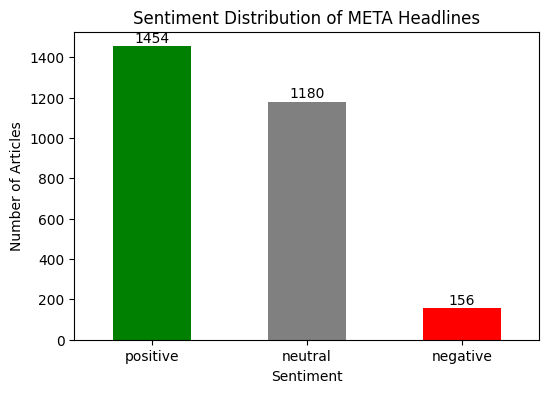

In [94]:
plot_sentiment(sentiment_counts, 'META ')

In [95]:
meta_related_data['Daily Returns'] = meta_related_data['Close'].pct_change()

In [96]:
meta_related_data[relevant_columns].head()

headline  polarity  \
Date                                                                      
2020-05-14  Alcoa CEO, Currently Presenting At BMO Global ...  0.000000   
2019-05-03  Shares of several consumer metals and mining c...  0.125000   
2019-04-17  Alcoa To Report Q1 Earnings After The Closing ...  0.000000   
2018-04-23  Watching Stock Futures Largely Unaffected, But... -0.016667   
2018-04-06  Watch Shares Of Century Aluminum, Alcoa, Arcon...  0.000000   

                 Close  Daily Returns  
Date                                   
2020-05-14  206.809998            NaN  
2019-05-03  195.470001      -0.054833  
2019-04-17  178.779999      -0.085384  
2018-04-23  165.839996      -0.072379  
2018-04-06  157.199997      -0.052098

Correlation

In [97]:
correlation = meta_related_data['polarity'].corr(meta_related_data['Daily Returns'])
print("Correlation between sentiment and daily stock returns:", correlation)

Correlation between sentiment and daily stock returns: -0.0519908889811984


In [98]:
correlation = meta_related_data['polarity'].corr(meta_related_data['Close'])
print("Correlation between sentiment and closing:", correlation)

Correlation between sentiment and closing: -0.056814205502487385


Get MICROSOFT companies stock dataset

In [99]:
# Access the MSFT dataset
msft_df = processed_data["MSFT"]

# Display the first 5 rows of the MSFT dataset
msft_df.head()

Date      Open      High       Low     Close  Adj Close      Volume  \
0 1986-03-13  0.088542  0.101563  0.088542  0.097222   0.059946  1031788800   
1 1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062087   308160000   
2 1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063158   133171200   
3 1986-03-18  0.102431  0.103299  0.098958  0.099826   0.061552    67766400   
4 1986-03-19  0.099826  0.100694  0.097222  0.098090   0.060482    47894400   

   SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
0     NaN     NaN  NaN   NaN          NaN        NaN  
1     NaN     NaN  NaN   NaN          NaN        NaN  
2     NaN     NaN  NaN   NaN          NaN        NaN  
3     NaN     NaN  NaN   NaN          NaN        NaN  
4     NaN     NaN  NaN   NaN          NaN        NaN

In [100]:
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9672 entries, 0 to 9671
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         9672 non-null   datetime64[ns]
 1   Open         9672 non-null   float64       
 2   High         9672 non-null   float64       
 3   Low          9672 non-null   float64       
 4   Close        9672 non-null   float64       
 5   Adj Close    9672 non-null   float64       
 6   Volume       9672 non-null   int64         
 7   SMA_50       9623 non-null   float64       
 8   EMA_50       9623 non-null   float64       
 9   RSI          9658 non-null   float64       
 10  MACD         9639 non-null   float64       
 11  MACD_signal  9639 non-null   float64       
 12  MACD_hist    9639 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 982.4 KB


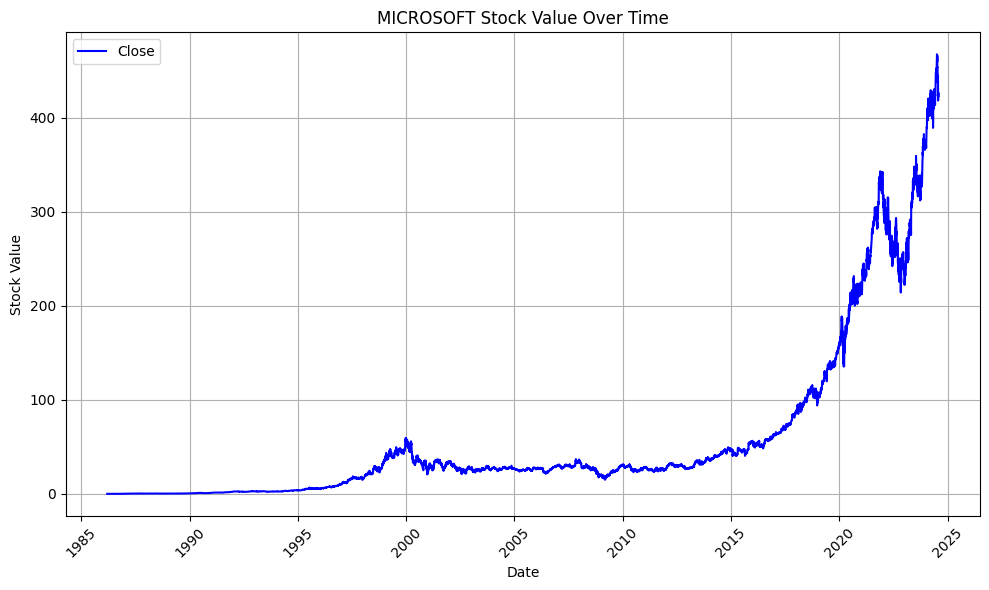

In [101]:
# Plot stock values for each company
plot_stock_data(msft_df, date_column='Date', stock_value_column='Close', title=f'MICROSOFT Stock Value Over Time')

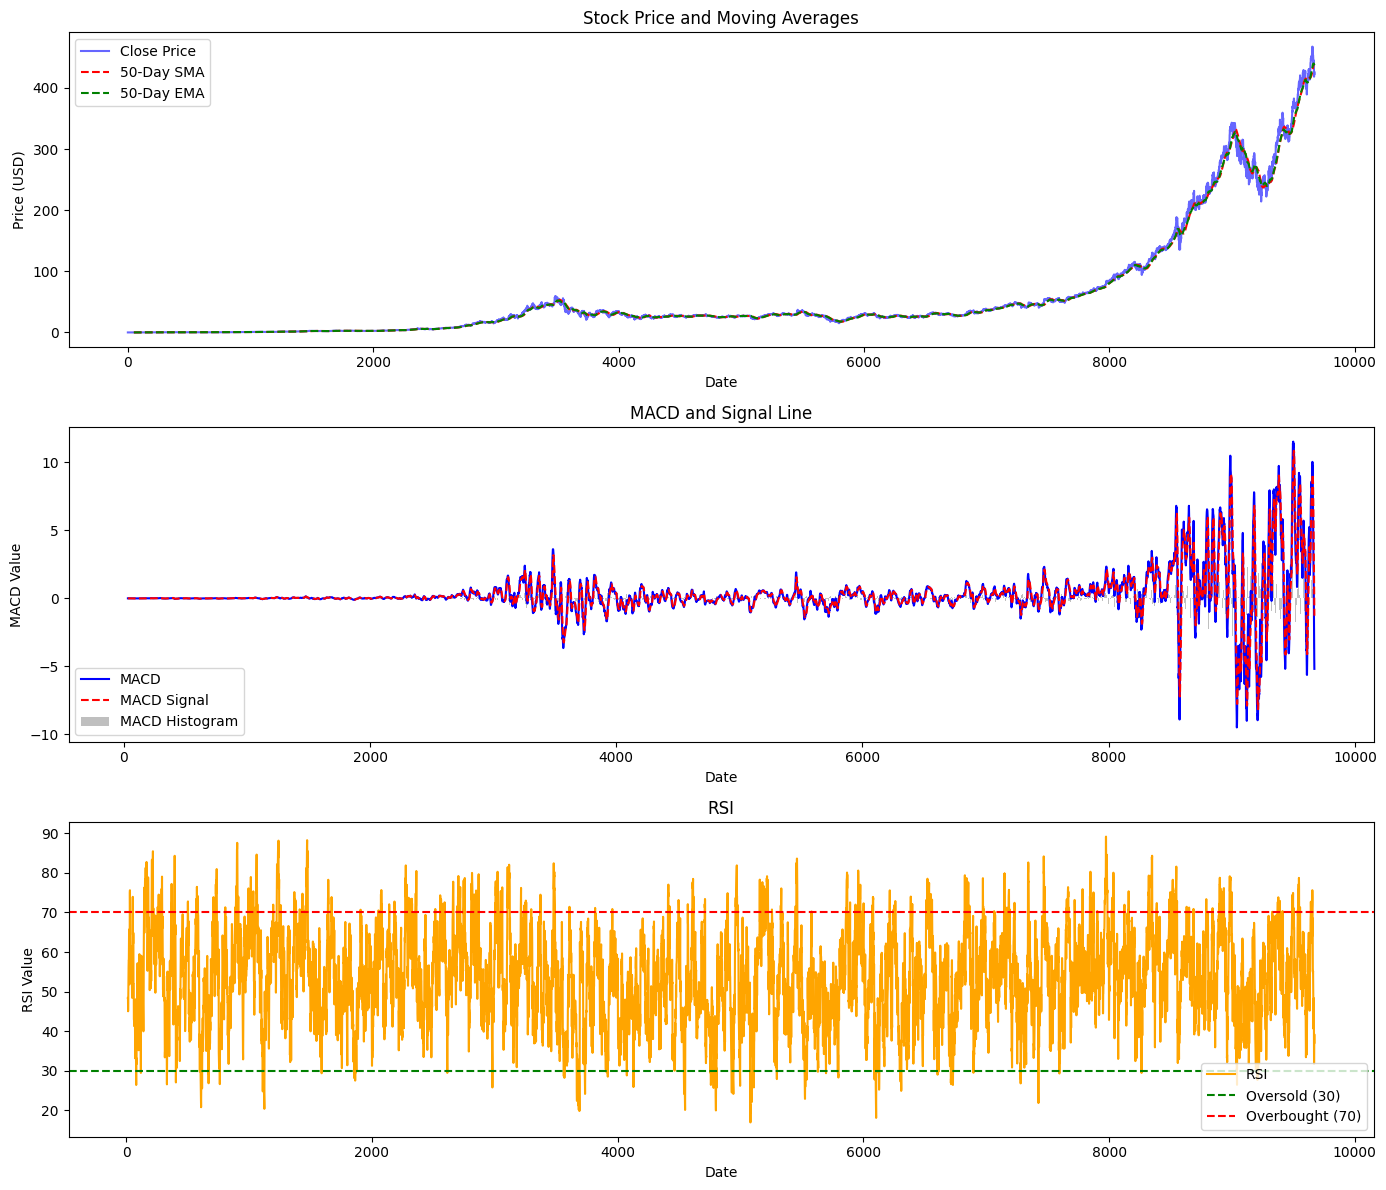

In [102]:
analyze_stock_data(msft_df)

In [103]:
# Ensure 'Date' column is in datetime format
msft_df['Date'] = pd.to_datetime(msft_df['Date'], errors='coerce')

# Set 'Date' as the index
msft_df.set_index('Date', inplace=True)

In [104]:
msft_df.head()

Open      High       Low     Close  Adj Close      Volume  \
Date                                                                        
1986-03-13  0.088542  0.101563  0.088542  0.097222   0.059946  1031788800   
1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062087   308160000   
1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063158   133171200   
1986-03-18  0.102431  0.103299  0.098958  0.099826   0.061552    67766400   
1986-03-19  0.099826  0.100694  0.097222  0.098090   0.060482    47894400   

            SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
Date                                                           
1986-03-13     NaN     NaN  NaN   NaN          NaN        NaN  
1986-03-14     NaN     NaN  NaN   NaN          NaN        NaN  
1986-03-17     NaN     NaN  NaN   NaN          NaN        NaN  
1986-03-18     NaN     NaN  NaN   NaN          NaN        NaN  
1986-03-19     NaN     NaN  NaN   NaN          NaN        NaN

Merge MSFT with rating dataset

In [105]:
msft_merged_data = pd.merge(text_data, msft_df, left_on='Date', right_index=True, how='inner')

In [106]:
msft_merged_data.head()

headline  \
Date                                                            
2020-06-05            Stocks That Hit 52-Week Highs On Friday   
2020-06-03         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26                      71 Biggest Movers From Friday   
2020-05-22       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22  B of A Securities Maintains Neutral on Agilent...   

                                                          url  \
Date                                                            
2020-06-05  https://www.benzinga.com/news/20/06/16190091/s...   
2020-06-03  https://www.benzinga.com/news/20/06/16170189/s...   
2020-05-26  https://www.benzinga.com/news/20/05/16103463/7...   
2020-05-22  https://www.benzinga.com/news/20/05/16095921/4...   
2020-05-22  https://www.benzinga.com/news/20/05/16095304/b...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-06-05  Benzinga Insights     A  10:30:54    10      30  2020      6    5   
2020-06-03  Benzinga Insights     A  10:45:20    10      45  2020      6    3   
2020-05-26         Lisa Levin     A  04:30:07     4      30  2020      5   26   
2020-05-22         Lisa Levin     A  12:45:06    12      45  2020      5   22   
2020-05-22         Vick Meyer     A  11:38:59    11      38  2020      5   22   

            ...         Low       Close   Adj Close    Volume    SMA_50  \
Date        ...                                                           
2020-06-05  ...  182.009995  187.199997  180.403564  39893600  174.8730   
2020-06-03  ...  183.580002  185.360001  178.630417  27311000  173.3758   
2020-05-26  ...  181.100006  181.570007  174.977966  36073600  168.1532   
2020-05-22  ...  182.539993  183.509995  176.847519  20826900  167.6984   
2020-05-22  ...  182.539993  183.509995  176.847519  20826900  167.6984   

                EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                 
2020-06-05  176.596974  60.706161  2.567082     2.916881  -0.349799  
2020-06-03  175.888450  59.461380  2.643727     3.149211  -0.505485  
2020-05-26  173.863327  54.276497  3.572572     4.272518  -0.699947  
2020-05-22  173.548769  57.262764  3.948136     4.447505  -0.499369  
2020-05-22  173.548769  57.262764  3.948136     4.447505  -0.499369  

[5 rows x 26 columns]

In [107]:
# Filter rows where 'headline' contains "MSFT"
msft_related_data = msft_merged_data[msft_merged_data['headline'].str.contains("MSFT", case=False, na=False)]

# Display the filtered DataFrame
msft_related_data

headline  \
Date                                                            
2010-10-29  Friday's Mid-Day Options Volume Leaders (MSFT,...   
2010-10-19  Dow Falls Below 11,000 (DJIA, BAC, IBM, AA, MSFT)   
2010-07-12  Monday’s Mid-Day Options Volume Leaders (C, BP...   
2010-06-01  Beaten-Down Blue Chips A Good Buy? (MSFT, CSCO...   
2010-03-31          The Dow Dogs Of Q1 (AA, T, VZ, PFE, MSFT)   
...                                                       ...   
2020-01-29  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
2010-02-03  Mad Money Lightning Round: Jim Prefers MRK, SY...   
2013-07-11  Tech Stocks Are Paying Record Dividends - But ...   
2013-07-02  CLSA's Managing Director Ed Maguire Sees Good ...   
2013-07-01  Zynga Hires Microsoft Exec Who Supported Xbox ...   

                                                          url  \
Date                                                            
2010-10-29  https://www.benzinga.com/market-update/10/10/5...   
2010-10-19  https://www.benzinga.com/general/10/10/533427/...   
2010-07-12  https://www.benzinga.com/market-update/10/07/3...   
2010-06-01  https://www.benzinga.com/general/10/06/308825/...   
2010-03-31  https://www.benzinga.com/general/202465/the-do...   
...                                                       ...   
2020-01-29  https://www.benzinga.com/pre-market-outlook/20...   
2010-02-03  https://www.benzinga.com/media/cnbc/109830/mad...   
2013-07-11  https://www.benzinga.com/news/earnings/13/07/3...   
2013-07-02  https://www.benzinga.com/media/cnbc/13/07/3723...   
2013-07-01  https://www.benzinga.com/news/13/07/3722178/zy...   

                       publisher stock      time  hour  minute  year  month  \
Date                                                                          
2010-10-29  Michael J. Zerinskas    AA  00:00:00     0       0  2010     10   
2010-10-19          Swing Trader    AA  00:00:00     0       0  2010     10   
2010-07-12  Michael J. Zerinskas    AA  00:00:00     0       0  2010      7   
2010-06-01          Swing Trader    AA  00:00:00     0       0  2010      6   
2010-03-31          Swing Trader    AA  00:00:00     0       0  2010      3   
...                          ...   ...       ...   ...     ...   ...    ...   
2020-01-29     Benzinga Newsdesk   YUM  00:00:00     0       0  2020      1   
2010-02-03         Monica Gerson   ZMH  00:00:00     0       0  2010      2   
2013-07-11            Tim Parker  ZNGA  00:00:00     0       0  2013      7   
2013-07-02         Jason Papallo  ZNGA  00:00:00     0       0  2013      7   
2013-07-01        Louis Bedigian  ZNGA  00:00:00     0       0  2013      7   

            day  ...         Low       Close   Adj Close     Volume    SMA_50  \
Date             ...                                                            
2010-10-29   29  ...   26.480000   26.670000   20.412271  114193200   24.7364   
2010-10-19   19  ...   24.950001   25.100000   19.210653   66150900   24.5582   
2010-07-12   12  ...   24.420000   24.830000   18.903164   49854200   26.4038   
2010-06-01    1  ...   25.520000   25.889999   19.710142   76152400   29.3332   
2010-03-31   31  ...   29.170000   29.290001   22.198418   63760000   28.9422   
...         ...  ...         ...         ...         ...        ...       ...   
2020-01-29   29  ...  165.690002  168.039993  161.049500   34754500  156.9018   
2010-02-03    3  ...   28.120001   28.629999   21.597210   61397900   30.0404   
2013-07-11   11  ...   34.900002   35.689999   29.457098   53638300   34.3032   
2013-07-02    2  ...   33.630001   33.939999   28.012707   37630000   33.9934   
2013-07-01    1  ...   34.330002   34.360001   28.359364   31055400   33.9312   

                EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                 
2010-10-29   25.120293  70.206706  0.404832     0.265640   0.139192  
2010-10-19   24.857557  53.923898  0.199356     0.095692   0.103664  

In [108]:
sentiment_analysis_parallel(msft_related_data, 'headlineClean')

[('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0), ('positive', 0.35), ('neutral', 0.0)]


headline  \
Date                                                            
2010-10-29  Friday's Mid-Day Options Volume Leaders (MSFT,...   
2010-10-19  Dow Falls Below 11,000 (DJIA, BAC, IBM, AA, MSFT)   
2010-07-12  Monday’s Mid-Day Options Volume Leaders (C, BP...   
2010-06-01  Beaten-Down Blue Chips A Good Buy? (MSFT, CSCO...   
2010-03-31          The Dow Dogs Of Q1 (AA, T, VZ, PFE, MSFT)   
...                                                       ...   
2020-01-29  Benzinga Pro's Top 5 Stocks To Watch For Wed.,...   
2010-02-03  Mad Money Lightning Round: Jim Prefers MRK, SY...   
2013-07-11  Tech Stocks Are Paying Record Dividends - But ...   
2013-07-02  CLSA's Managing Director Ed Maguire Sees Good ...   
2013-07-01  Zynga Hires Microsoft Exec Who Supported Xbox ...   

                                                          url  \
Date                                                            
2010-10-29  https://www.benzinga.com/market-update/10/10/5...   
2010-10-19  https://www.benzinga.com/general/10/10/533427/...   
2010-07-12  https://www.benzinga.com/market-update/10/07/3...   
2010-06-01  https://www.benzinga.com/general/10/06/308825/...   
2010-03-31  https://www.benzinga.com/general/202465/the-do...   
...                                                       ...   
2020-01-29  https://www.benzinga.com/pre-market-outlook/20...   
2010-02-03  https://www.benzinga.com/media/cnbc/109830/mad...   
2013-07-11  https://www.benzinga.com/news/earnings/13/07/3...   
2013-07-02  https://www.benzinga.com/media/cnbc/13/07/3723...   
2013-07-01  https://www.benzinga.com/news/13/07/3722178/zy...   

                       publisher stock      time  hour  minute  year  month  \
Date                                                                          
2010-10-29  Michael J. Zerinskas    AA  00:00:00     0       0  2010     10   
2010-10-19          Swing Trader    AA  00:00:00     0       0  2010     10   
2010-07-12  Michael J. Zerinskas    AA  00:00:00     0       0  2010      7   
2010-06-01          Swing Trader    AA  00:00:00     0       0  2010      6   
2010-03-31          Swing Trader    AA  00:00:00     0       0  2010      3   
...                          ...   ...       ...   ...     ...   ...    ...   
2020-01-29     Benzinga Newsdesk   YUM  00:00:00     0       0  2020      1   
2010-02-03         Monica Gerson   ZMH  00:00:00     0       0  2010      2   
2013-07-11            Tim Parker  ZNGA  00:00:00     0       0  2013      7   
2013-07-02         Jason Papallo  ZNGA  00:00:00     0       0  2013      7   
2013-07-01        Louis Bedigian  ZNGA  00:00:00     0       0  2013      7   

            day  ...   Adj Close     Volume    SMA_50      EMA_50        RSI  \
Date             ...                                                           
2010-10-29   29  ...   20.412271  114193200   24.7364   25.120293  70.206706   
2010-10-19   19  ...   19.210653   66150900   24.5582   24.857557  53.923898   
2010-07-12   12  ...   18.903164   49854200   26.4038   26.071358  47.708610   
2010-06-01    1  ...   19.710142   76152400   29.3332   28.674654  30.657443   
2010-03-31   31  ...   22.198418   63760000   28.9422   29.212814  49.494639   
...         ...  ...         ...        ...       ...         ...        ...   
2020-01-29   29  ...  161.049500   34754500  156.9018  157.453078  65.965064   
2010-02-03    3  ...   21.597210   61397900   30.0404   29.537829  38.499351   
2013-07-11   11  ...   29.457098   53638300   34.3032   33.728151  64.923500   
2013-07-02    2  ...   28.012707   37630000   33.9934   33.496590  47.001869   
2013-07-01    1  ...   28.359364   31055400   33.9312   33.478491  51.347787   

                MACD  MACD_signal  MACD_hist  sentiment  polarity  
Date                                                               
2010-10-29  0.404832     0.265640   0.139192    neutral    0.0000  
2010-10-19  0.199356     0.095692   0.103664    neutral    0.0000  
2010-07-12 -0.644161

In [109]:
sentiment_counts = msft_related_data['sentiment'].value_counts()

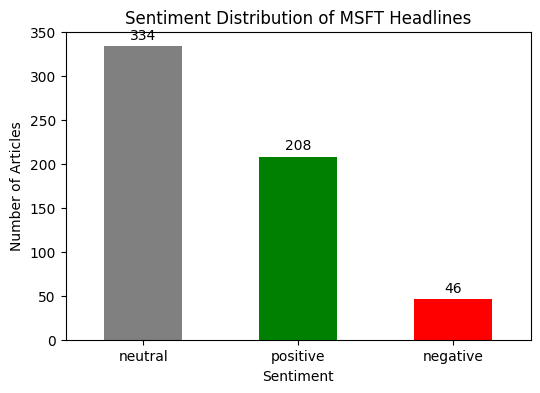

In [110]:
plot_sentiment(sentiment_counts, 'MSFT ')

In [111]:
msft_related_data['Daily Returns'] = msft_related_data['Close'].pct_change()

In [112]:
msft_related_data[relevant_columns].head()

headline  polarity  \
Date                                                                      
2010-10-29  Friday's Mid-Day Options Volume Leaders (MSFT,...      0.00   
2010-10-19  Dow Falls Below 11,000 (DJIA, BAC, IBM, AA, MSFT)      0.00   
2010-07-12  Monday’s Mid-Day Options Volume Leaders (C, BP...      0.00   
2010-06-01  Beaten-Down Blue Chips A Good Buy? (MSFT, CSCO...      0.35   
2010-03-31          The Dow Dogs Of Q1 (AA, T, VZ, PFE, MSFT)      0.00   

                Close  Daily Returns  
Date                                  
2010-10-29  26.670000            NaN  
2010-10-19  25.100000      -0.058868  
2010-07-12  24.830000      -0.010757  
2010-06-01  25.889999       0.042690  
2010-03-31  29.290001       0.131325

Correlation

In [113]:
correlation = msft_related_data['polarity'].corr(msft_related_data['Daily Returns'])
print("Correlation between sentiment and daily stock returns:", correlation)

Correlation between sentiment and daily stock returns: 0.1577120195596601


In [114]:
correlation = msft_related_data['polarity'].corr(msft_related_data['Close'])
print("Correlation between sentiment and closing:", correlation)

Correlation between sentiment and closing: 0.15069039096802614


Get NVIDIA companies stock dataset

In [115]:
# Access the MSFT dataset
nvda_df = processed_data["NVDA"]

# Display the first 5 rows of the NVDA dataset
nvda_df.head()

Date      Open      High       Low     Close  Adj Close      Volume  \
0 1999-01-22  0.043750  0.048828  0.038802  0.041016   0.037621  2714688000   
1 1999-01-25  0.044271  0.045833  0.041016  0.045313   0.041562   510480000   
2 1999-01-26  0.045833  0.046745  0.041146  0.041797   0.038337   343200000   
3 1999-01-27  0.041927  0.042969  0.039583  0.041667   0.038218   244368000   
4 1999-01-28  0.041667  0.041927  0.041276  0.041536   0.038098   227520000   

   SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
0     NaN     NaN  NaN   NaN          NaN        NaN  
1     NaN     NaN  NaN   NaN          NaN        NaN  
2     NaN     NaN  NaN   NaN          NaN        NaN  
3     NaN     NaN  NaN   NaN          NaN        NaN  
4     NaN     NaN  NaN   NaN          NaN        NaN

In [116]:
nvda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6421 entries, 0 to 6420
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         6421 non-null   datetime64[ns]
 1   Open         6421 non-null   float64       
 2   High         6421 non-null   float64       
 3   Low          6421 non-null   float64       
 4   Close        6421 non-null   float64       
 5   Adj Close    6421 non-null   float64       
 6   Volume       6421 non-null   int64         
 7   SMA_50       6372 non-null   float64       
 8   EMA_50       6372 non-null   float64       
 9   RSI          6407 non-null   float64       
 10  MACD         6388 non-null   float64       
 11  MACD_signal  6388 non-null   float64       
 12  MACD_hist    6388 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 652.3 KB


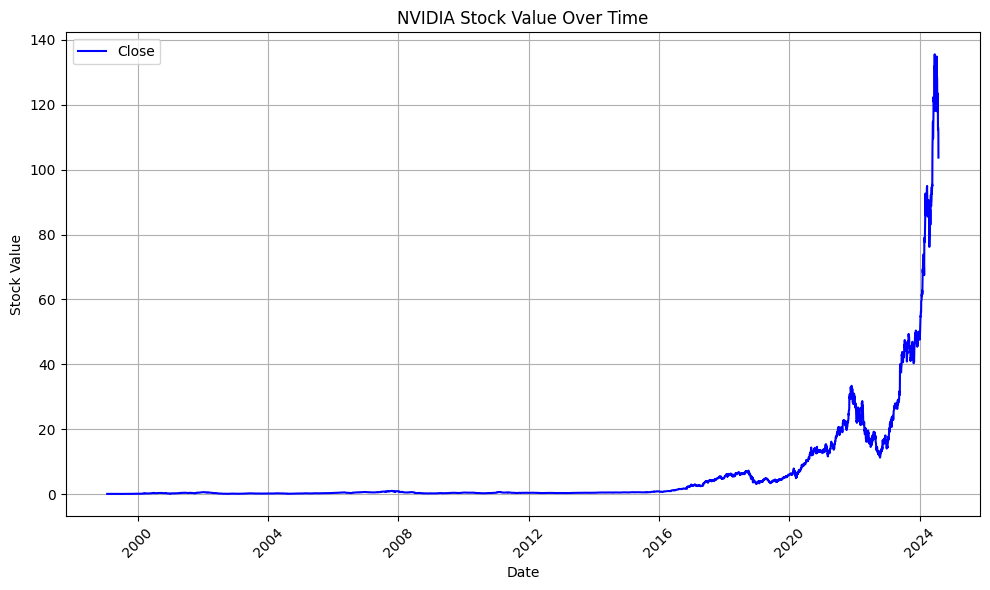

In [117]:
# Plot stock values for each company
plot_stock_data(nvda_df, date_column='Date', stock_value_column='Close', title=f'NVIDIA Stock Value Over Time')

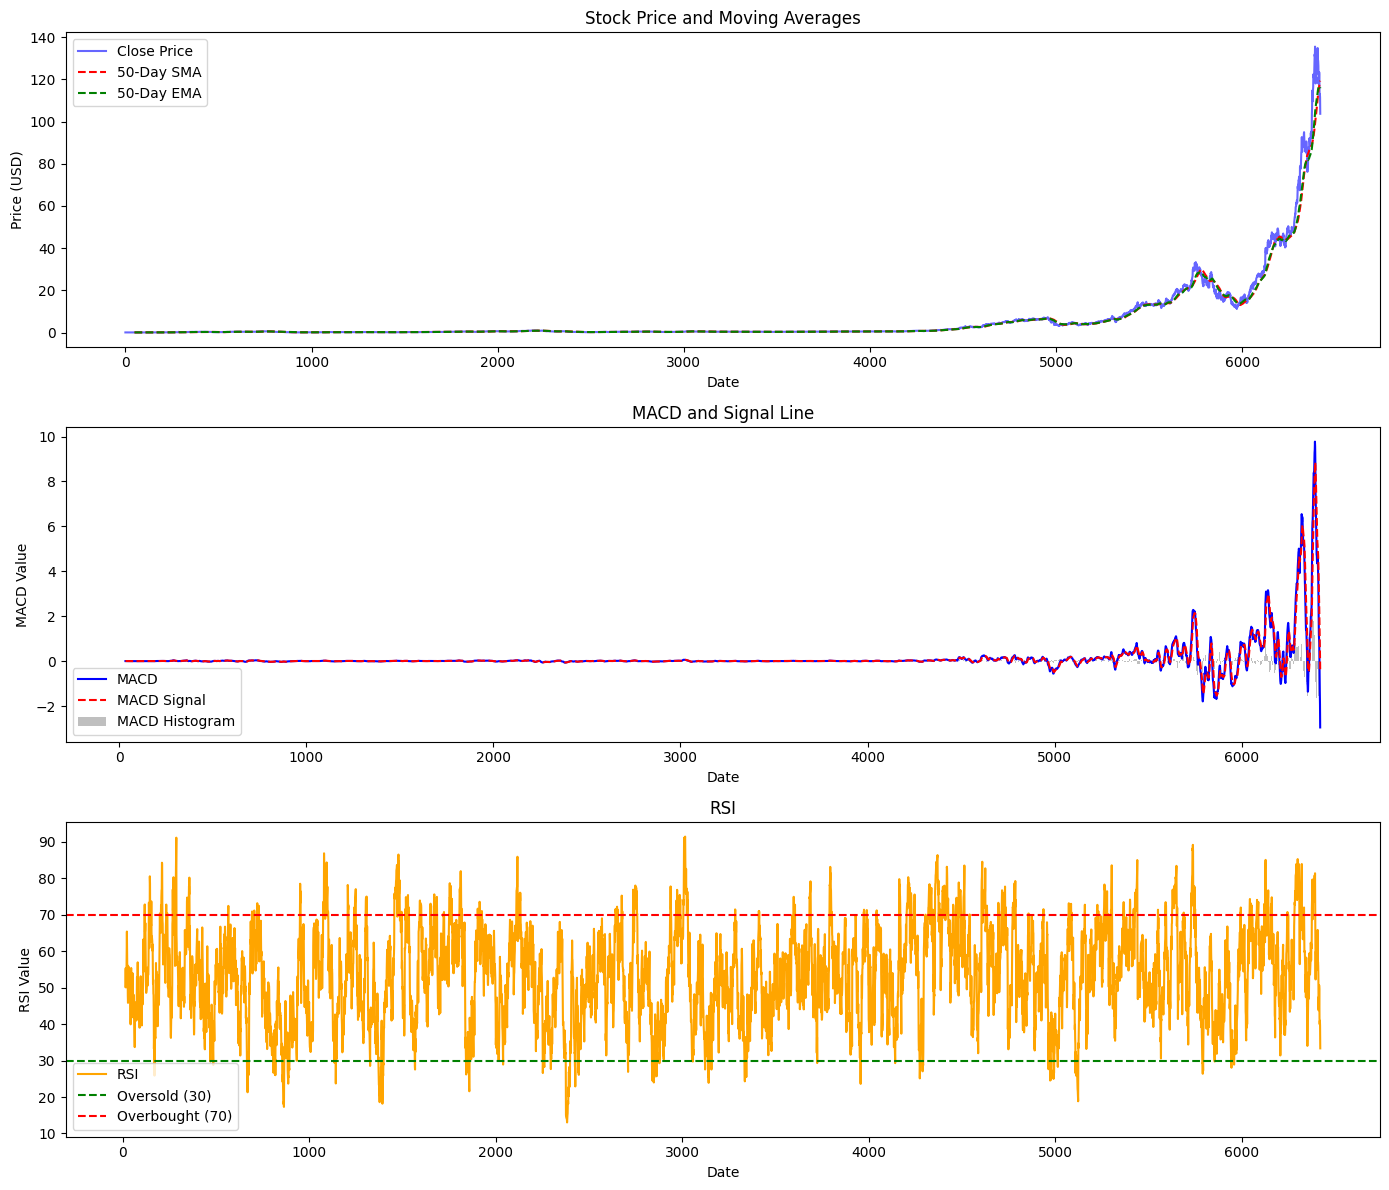

In [118]:
analyze_stock_data(nvda_df)

In [119]:
# Ensure 'Date' column is in datetime format
nvda_df['Date'] = pd.to_datetime(nvda_df['Date'], errors='coerce')

# Set 'Date' as the index
nvda_df.set_index('Date', inplace=True)

In [120]:
nvda_df.head()

Open      High       Low     Close  Adj Close      Volume  \
Date                                                                        
1999-01-22  0.043750  0.048828  0.038802  0.041016   0.037621  2714688000   
1999-01-25  0.044271  0.045833  0.041016  0.045313   0.041562   510480000   
1999-01-26  0.045833  0.046745  0.041146  0.041797   0.038337   343200000   
1999-01-27  0.041927  0.042969  0.039583  0.041667   0.038218   244368000   
1999-01-28  0.041667  0.041927  0.041276  0.041536   0.038098   227520000   

            SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
Date                                                           
1999-01-22     NaN     NaN  NaN   NaN          NaN        NaN  
1999-01-25     NaN     NaN  NaN   NaN          NaN        NaN  
1999-01-26     NaN     NaN  NaN   NaN          NaN        NaN  
1999-01-27     NaN     NaN  NaN   NaN          NaN        NaN  
1999-01-28     NaN     NaN  NaN   NaN          NaN        NaN

Merge NVDA with rating dataset

In [121]:
nvda_merged_data = pd.merge(text_data, nvda_df, left_on='Date', right_index=True, how='inner')

In [122]:
nvda_merged_data.head()

headline  \
Date                                                            
2020-06-05            Stocks That Hit 52-Week Highs On Friday   
2020-06-03         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26                      71 Biggest Movers From Friday   
2020-05-22       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22  B of A Securities Maintains Neutral on Agilent...   

                                                          url  \
Date                                                            
2020-06-05  https://www.benzinga.com/news/20/06/16190091/s...   
2020-06-03  https://www.benzinga.com/news/20/06/16170189/s...   
2020-05-26  https://www.benzinga.com/news/20/05/16103463/7...   
2020-05-22  https://www.benzinga.com/news/20/05/16095921/4...   
2020-05-22  https://www.benzinga.com/news/20/05/16095304/b...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-06-05  Benzinga Insights     A  10:30:54    10      30  2020      6    5   
2020-06-03  Benzinga Insights     A  10:45:20    10      45  2020      6    3   
2020-05-26         Lisa Levin     A  04:30:07     4      30  2020      5   26   
2020-05-22         Lisa Levin     A  12:45:06    12      45  2020      5   22   
2020-05-22         Vick Meyer     A  11:38:59    11      38  2020      5   22   

            ...      Low    Close Adj Close      Volume    SMA_50    EMA_50  \
Date        ...                                                               
2020-06-05  ...  8.70800  8.92000  8.893502   481748000  7.583320  7.789628   
2020-06-03  ...  8.70000  8.76950  8.739462   365440000  7.476990  7.701735   
2020-05-26  ...  8.67200  8.71775  8.687888   770780000  7.055165  7.424983   
2020-05-22  ...  8.71325  9.02625  8.995332  1038764000  7.001230  7.372217   
2020-05-22  ...  8.71325  9.02625  8.995332  1038764000  7.001230  7.372217   

                  RSI      MACD  MACD_signal  MACD_hist  
Date                                                     
2020-06-05  64.199443  0.377746     0.415311  -0.037564  
2020-06-03  61.812231  0.404571     0.434596  -0.030026  
2020-05-26  64.116704  0.511615     0.444781   0.066834  
2020-05-22  71.241649  0.525212     0.428073   0.097139  
2020-05-22  71.241649  0.525212     0.428073   0.097139  

[5 rows x 26 columns]

In [123]:
# Filter rows where 'headline' contains "NVDA"
nvda_related_data = nvda_merged_data[nvda_merged_data['headline'].str.contains("NVDA", case=False, na=False)]

# Display the filtered DataFrame
nvda_related_data

headline  \
Date                                                            
2011-05-13  Top day traders Stocks and nalyst Upgrades & D...   
2011-05-12  Stocks To Watch For May 13 (A, JWN, NVDA, YUM,...   
2010-11-12  Stocks To Watch For November 12 (CPKI, A, DIS,...   
2011-01-11  Tuesday's Mid-Day Options Volume Leaders (BAC,...   
2011-01-11     Benzinga's Top Downgrades (AA, AYI, AMR, NVDA)   
...                                                       ...   
2010-07-27  Benzinga’s Top Pre-Market NASDAQ Losers (MNTA,...   
2011-03-08     Benzinga's Top Upgrades (NVDA, ANF, MIPS, WFT)   
2017-06-09                  Shorts Attack NVDA, TSLA and RLGT   
2011-01-11  Auriga U.S.A Increases Its Price Target on NVI...   
2019-12-31  Benzinga Pro's Top 5 Stocks To Watch For Tues....   

                                                          url  \
Date                                                            
2011-05-13  https://www.benzinga.com/11/05/1082437/top-day...   
2011-05-12  https://www.benzinga.com/news/earnings/11/05/1...   
2010-11-12  https://www.benzinga.com/market-update/10/11/6...   
2011-01-11  https://www.benzinga.com/options/11/01/770225/...   
2011-01-11  https://www.benzinga.com/analyst-ratings/downg...   
...                                                       ...   
2010-07-27  https://www.benzinga.com/markets/company-news/...   
2011-03-08  https://www.benzinga.com/analyst-ratings/upgra...   
2017-06-09  https://www.benzinga.com/17/06/9592104/shorts-...   
2011-01-11  https://www.benzinga.com/analyst-ratings/price...   
2019-12-31  https://www.benzinga.com/pre-market-outlook/19...   

                       publisher stock      time  hour  minute  year  month  \
Date                                                                          
2011-05-13             CEO World     A  00:00:00     0       0  2011      5   
2011-05-12            Lisa Levin     A  00:00:00     0       0  2011      5   
2010-11-12         Monica Gerson     A  00:00:00     0       0  2010     11   
2011-01-11  Michael J. Zerinskas    AA  00:00:00     0       0  2011      1   
2011-01-11         Monica Gerson    AA  00:00:00     0       0  2011      1   
...                          ...   ...       ...   ...     ...   ...    ...   
2010-07-27         Monica Gerson  WERN  00:00:00     0       0  2010      7   
2011-03-08            Lisa Levin   WFT  00:00:00     0       0  2011      3   
2017-06-09                 Zacks   WIX  00:00:00     0       0  2017      6   
2011-01-11        Benzinga Staff   YGE  00:00:00     0       0  2011      1   
2019-12-31     Benzinga Newsdesk  ZNGA  00:00:00     0       0  2019     12   

            day  ...      Low    Close Adj Close      Volume    SMA_50  \
Date             ...                                                     
2011-05-13   13  ...  0.45300  0.45650  0.418714  2025192000  0.465290   
2011-05-12   12  ...  0.49375  0.51250  0.470079  1224000000  0.466595   
2010-11-12   12  ...  0.32575  0.33150  0.304061  2142560000  0.286145   
2011-01-11   11  ...  0.49675  0.50775  0.465722  2711088000  0.363150   
2011-01-11   11  ...  0.49675  0.50775  0.465722  2711088000  0.363150   
...         ...  ...      ...      ...       ...         ...       ...   
2010-07-27   27  ...  0.25825  0.26150  0.239855   683472000  0.286090   
2011-03-08    8  ...  0.47800  0.48875  0.448295  1947184000  0.543410   
2017-06-09    9  ...  3.56875  3.74000  3.694325  3692928000  2.968650   
2011-01-11   11  ...  0.49675  0.50775  0.465722  2711088000  0.363150   
2019-12-31   31  ...  5.75325  5.88250  5.858848   231004000  5.366015   

              EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                               
2011-05-13  0.478357  43.564697  0.005215     0.004434   0.000781  
2011-05-12  0.479249  64.536565  0.008268     0.004238   0.004030  
2010-11-12  0.290222  76.829707  0.011133     0.009510   0.001623  
2011-01-11  0.372764  86.44647

In [124]:
sentiment_analysis_parallel(nvda_related_data, 'headlineClean')

[('positive', 0.5), ('neutral', 0.0), ('neutral', 0.0), ('neutral', 0.0), ('positive', 0.5)]


headline  \
Date                                                            
2011-05-13  Top day traders Stocks and nalyst Upgrades & D...   
2011-05-12  Stocks To Watch For May 13 (A, JWN, NVDA, YUM,...   
2010-11-12  Stocks To Watch For November 12 (CPKI, A, DIS,...   
2011-01-11  Tuesday's Mid-Day Options Volume Leaders (BAC,...   
2011-01-11     Benzinga's Top Downgrades (AA, AYI, AMR, NVDA)   
...                                                       ...   
2010-07-27  Benzinga’s Top Pre-Market NASDAQ Losers (MNTA,...   
2011-03-08     Benzinga's Top Upgrades (NVDA, ANF, MIPS, WFT)   
2017-06-09                  Shorts Attack NVDA, TSLA and RLGT   
2011-01-11  Auriga U.S.A Increases Its Price Target on NVI...   
2019-12-31  Benzinga Pro's Top 5 Stocks To Watch For Tues....   

                                                          url  \
Date                                                            
2011-05-13  https://www.benzinga.com/11/05/1082437/top-day...   
2011-05-12  https://www.benzinga.com/news/earnings/11/05/1...   
2010-11-12  https://www.benzinga.com/market-update/10/11/6...   
2011-01-11  https://www.benzinga.com/options/11/01/770225/...   
2011-01-11  https://www.benzinga.com/analyst-ratings/downg...   
...                                                       ...   
2010-07-27  https://www.benzinga.com/markets/company-news/...   
2011-03-08  https://www.benzinga.com/analyst-ratings/upgra...   
2017-06-09  https://www.benzinga.com/17/06/9592104/shorts-...   
2011-01-11  https://www.benzinga.com/analyst-ratings/price...   
2019-12-31  https://www.benzinga.com/pre-market-outlook/19...   

                       publisher stock      time  hour  minute  year  month  \
Date                                                                          
2011-05-13             CEO World     A  00:00:00     0       0  2011      5   
2011-05-12            Lisa Levin     A  00:00:00     0       0  2011      5   
2010-11-12         Monica Gerson     A  00:00:00     0       0  2010     11   
2011-01-11  Michael J. Zerinskas    AA  00:00:00     0       0  2011      1   
2011-01-11         Monica Gerson    AA  00:00:00     0       0  2011      1   
...                          ...   ...       ...   ...     ...   ...    ...   
2010-07-27         Monica Gerson  WERN  00:00:00     0       0  2010      7   
2011-03-08            Lisa Levin   WFT  00:00:00     0       0  2011      3   
2017-06-09                 Zacks   WIX  00:00:00     0       0  2017      6   
2011-01-11        Benzinga Staff   YGE  00:00:00     0       0  2011      1   
2019-12-31     Benzinga Newsdesk  ZNGA  00:00:00     0       0  2019     12   

            day  ... Adj Close      Volume    SMA_50    EMA_50        RSI  \
Date             ...                                                        
2011-05-13   13  ...  0.418714  2025192000  0.465290  0.478357  43.564697   
2011-05-12   12  ...  0.470079  1224000000  0.466595  0.479249  64.536565   
2010-11-12   12  ...  0.304061  2142560000  0.286145  0.290222  76.829707   
2011-01-11   11  ...  0.465722  2711088000  0.363150  0.372764  86.446476   
2011-01-11   11  ...  0.465722  2711088000  0.363150  0.372764  86.446476   
...         ...  ...       ...         ...       ...       ...        ...   
2010-07-27   27  ...  0.239855   683472000  0.286090  0.292292  44.036628   
2011-03-08    8  ...  0.448295  1947184000  0.543410  0.527706  35.856811   
2017-06-09    9  ...  3.694325  3692928000  2.968650  3.141595  65.450746   
2011-01-11   11  ...  0.465722  2711088000  0.363150  0.372764  86.446476   
2019-12-31   31  ...  5.858848   231004000  5.366015  5.377067  65.859187   

                MACD  MACD_signal  MACD_hist  sentiment  polarity  
Date                                                               
2011-05-13  0.005215     0.004434   0.000781   positive       0.5  
2011-05-12  0.008268     0.004238   0.004030    neutral       0.0  
2010-11-12  0.011133     0.009510   0.001623    neutral    

In [125]:
sentiment_counts = nvda_related_data['sentiment'].value_counts()

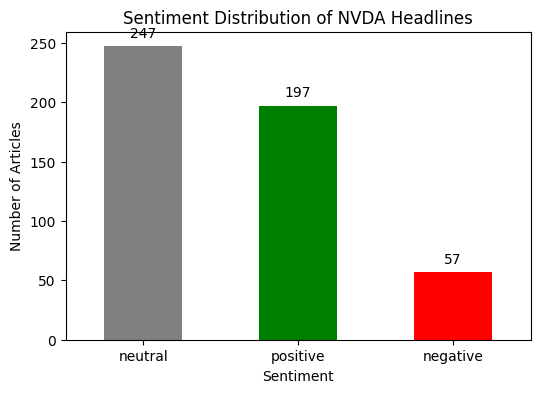

In [126]:
plot_sentiment(sentiment_counts, 'NVDA ')

In [127]:
nvda_related_data['Daily Returns'] = nvda_related_data['Close'].pct_change()

In [128]:
nvda_related_data[relevant_columns].head()

headline  polarity  \
Date                                                                      
2011-05-13  Top day traders Stocks and nalyst Upgrades & D...       0.5   
2011-05-12  Stocks To Watch For May 13 (A, JWN, NVDA, YUM,...       0.0   
2010-11-12  Stocks To Watch For November 12 (CPKI, A, DIS,...       0.0   
2011-01-11  Tuesday's Mid-Day Options Volume Leaders (BAC,...       0.0   
2011-01-11     Benzinga's Top Downgrades (AA, AYI, AMR, NVDA)       0.5   

              Close  Daily Returns  
Date                                
2011-05-13  0.45650            NaN  
2011-05-12  0.51250       0.122672  
2010-11-12  0.33150      -0.353171  
2011-01-11  0.50775       0.531674  
2011-01-11  0.50775       0.000000

Correlation

In [129]:
correlation = nvda_related_data['polarity'].corr(nvda_related_data['Daily Returns'])
print("Correlation between sentiment and daily stock returns:", correlation)

Correlation between sentiment and daily stock returns: 0.1128907998408714


In [130]:
correlation = nvda_related_data['polarity'].corr(nvda_related_data['Close'])
print("Correlation between sentiment and closing:", correlation)

Correlation between sentiment and closing: 0.08766498802603163


Get TESLA companies stock dataset

In [131]:
# Access the TSLA dataset
tsla_df = processed_data["TSLA"]

# Display the first 5 rows of the TSLA dataset
tsla_df.head()

Date      Open      High       Low     Close  Adj Close     Volume  \
0 2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
1 2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2 2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
3 2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
4 2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

   SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
0     NaN     NaN  NaN   NaN          NaN        NaN  
1     NaN     NaN  NaN   NaN          NaN        NaN  
2     NaN     NaN  NaN   NaN          NaN        NaN  
3     NaN     NaN  NaN   NaN          NaN        NaN  
4     NaN     NaN  NaN   NaN          NaN        NaN

In [132]:
tsla_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3545 entries, 0 to 3544
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         3545 non-null   datetime64[ns]
 1   Open         3545 non-null   float64       
 2   High         3545 non-null   float64       
 3   Low          3545 non-null   float64       
 4   Close        3545 non-null   float64       
 5   Adj Close    3545 non-null   float64       
 6   Volume       3545 non-null   int64         
 7   SMA_50       3496 non-null   float64       
 8   EMA_50       3496 non-null   float64       
 9   RSI          3531 non-null   float64       
 10  MACD         3512 non-null   float64       
 11  MACD_signal  3512 non-null   float64       
 12  MACD_hist    3512 non-null   float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usage: 360.2 KB


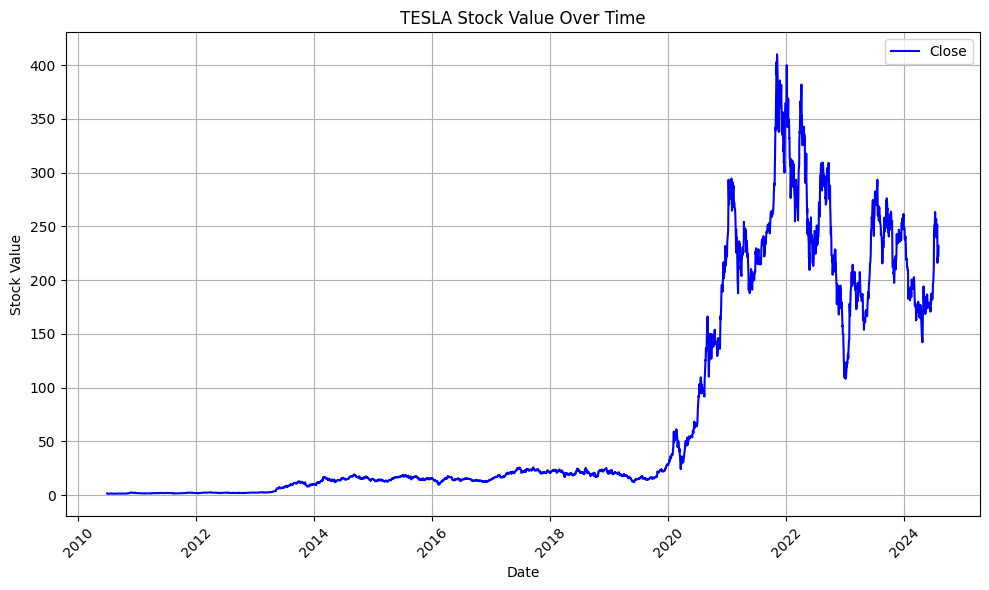

In [133]:
# Plot stock values for each company
plot_stock_data(tsla_df, date_column='Date', stock_value_column='Close', title=f'TESLA Stock Value Over Time')

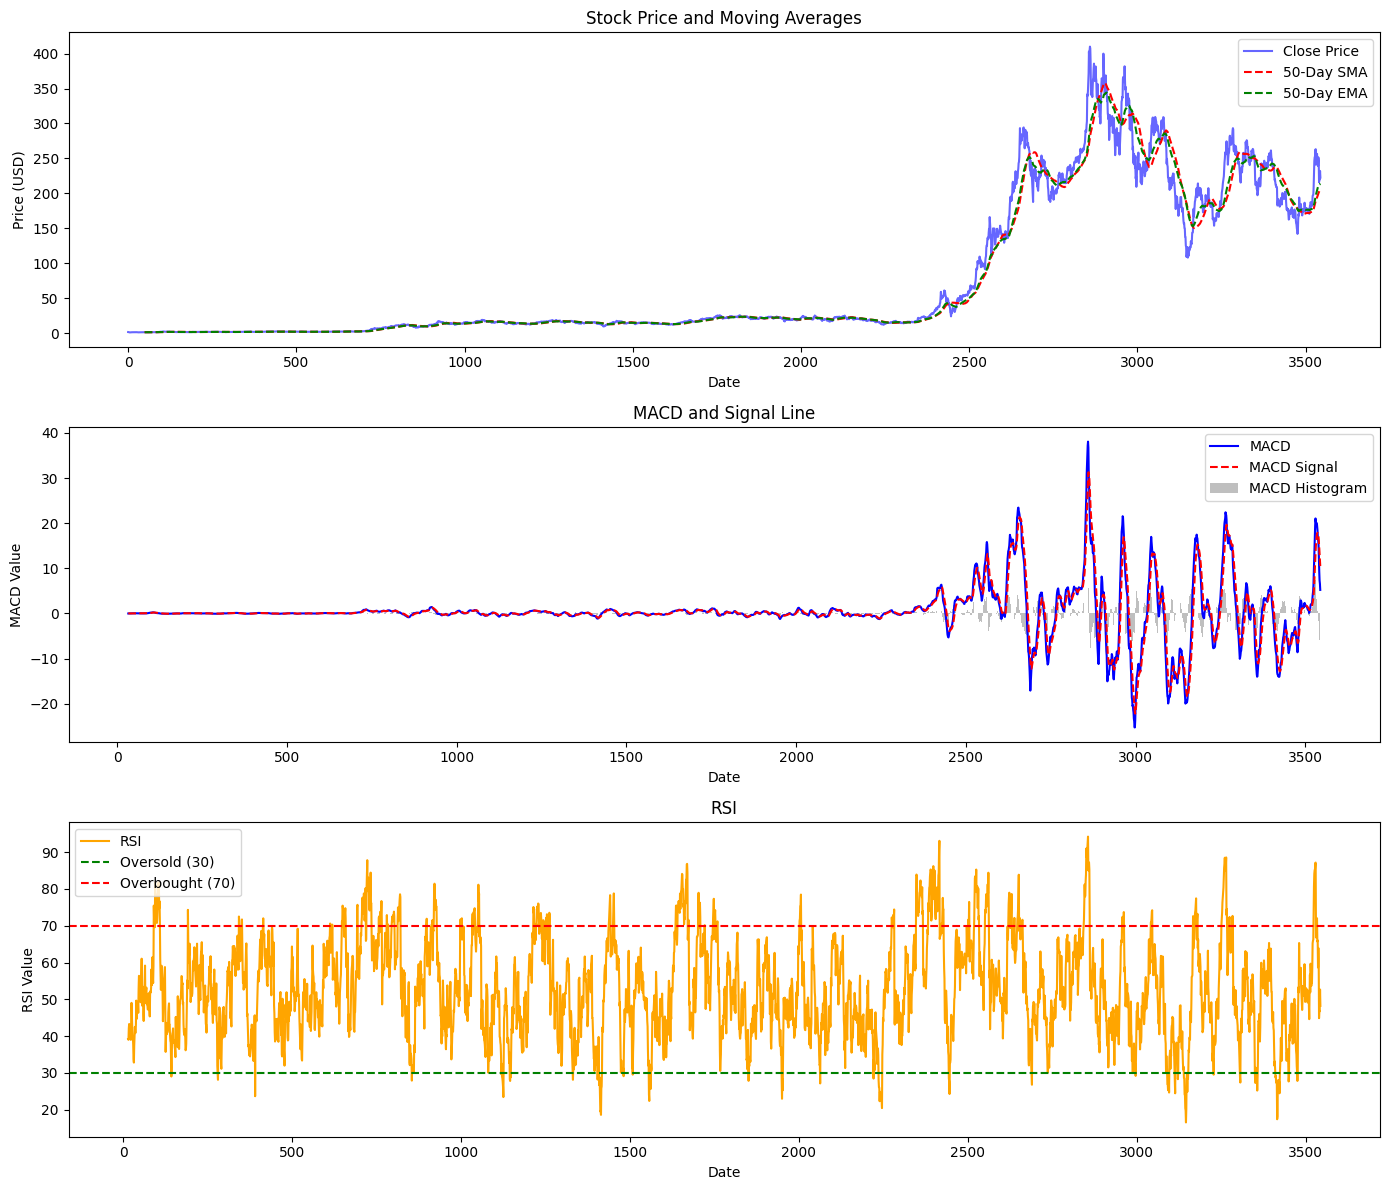

In [134]:
analyze_stock_data(tsla_df)

In [135]:
# Ensure 'Date' column is in datetime format
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'], errors='coerce')

# Set 'Date' as the index
tsla_df.set_index('Date', inplace=True)

In [136]:
tsla_df.head()

Open      High       Low     Close  Adj Close     Volume  \
Date                                                                       
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500   
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500   
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000   
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000   
2010-07-06  1.333333  1.333333  1.055333  1.074000   1.074000  103003500   

            SMA_50  EMA_50  RSI  MACD  MACD_signal  MACD_hist  
Date                                                           
2010-06-29     NaN     NaN  NaN   NaN          NaN        NaN  
2010-06-30     NaN     NaN  NaN   NaN          NaN        NaN  
2010-07-01     NaN     NaN  NaN   NaN          NaN        NaN  
2010-07-02     NaN     NaN  NaN   NaN          NaN        NaN  
2010-07-06     NaN     NaN  NaN   NaN          NaN        NaN

Merge TSLA with rating dataset

In [137]:
tsla_merged_data = pd.merge(text_data, tsla_df, left_on='Date', right_index=True, how='inner')

In [138]:
tsla_merged_data.head()

headline  \
Date                                                            
2020-06-05            Stocks That Hit 52-Week Highs On Friday   
2020-06-03         Stocks That Hit 52-Week Highs On Wednesday   
2020-05-26                      71 Biggest Movers From Friday   
2020-05-22       46 Stocks Moving In Friday's Mid-Day Session   
2020-05-22  B of A Securities Maintains Neutral on Agilent...   

                                                          url  \
Date                                                            
2020-06-05  https://www.benzinga.com/news/20/06/16190091/s...   
2020-06-03  https://www.benzinga.com/news/20/06/16170189/s...   
2020-05-26  https://www.benzinga.com/news/20/05/16103463/7...   
2020-05-22  https://www.benzinga.com/news/20/05/16095921/4...   
2020-05-22  https://www.benzinga.com/news/20/05/16095304/b...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2020-06-05  Benzinga Insights     A  10:30:54    10      30  2020      6    5   
2020-06-03  Benzinga Insights     A  10:45:20    10      45  2020      6    3   
2020-05-26         Lisa Levin     A  04:30:07     4      30  2020      5   26   
2020-05-22         Lisa Levin     A  12:45:06    12      45  2020      5   22   
2020-05-22         Vick Meyer     A  11:38:59    11      38  2020      5   22   

            ...        Low      Close  Adj Close     Volume     SMA_50  \
Date        ...                                                          
2020-06-05  ...  57.746666  59.043999  59.043999  117178500  48.540520   
2020-06-03  ...  58.673332  58.863998  58.863998  119242500  47.599467   
2020-05-26  ...  54.380669  54.591331  54.591331  121345500  44.135853   
2020-05-22  ...  54.133331  54.458668  54.458668  149812500  43.772853   
2020-05-22  ...  54.133331  54.458668  54.458668  149812500  43.772853   

               EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                
2020-06-05  50.561389  64.631306  2.561091     2.498730   0.062361  
2020-06-03  49.912704  66.143032  2.600974     2.471092   0.129882  
2020-05-26  47.972897  60.396315  2.385505     2.676704  -0.291199  
2020-05-22  47.702756  60.100135  2.485081     2.749504  -0.264423  
2020-05-22  47.702756  60.100135  2.485081     2.749504  -0.264423  

[5 rows x 26 columns]

In [139]:
# Filter rows where 'headline' contains "TSLA"
tsla_related_data = tsla_merged_data[tsla_merged_data['headline'].str.contains("TSLA", case=False, na=False)]

# Display the filtered DataFrame
tsla_related_data

headline  \
Date                                                            
2015-12-29  UBS Says 5 Most Shorted Stocks On Monday Were ...   
2011-05-04  Earnings Scheduled For May 4 (PCG, WFMI, TWX, ...   
2019-12-24  Benzinga Pro's Top 5 Stocks To Watch For Tues....   
2011-03-31  Benzinga's Volume Movers (TSLA, DNDN, ACXM, MAKO)   
2013-07-10  What to Expect From Tesla Shares After Joining...   
...                                                       ...   
2020-01-03  Benzinga Pro's Top 5 Stocks To Watch For Fri.,...   
2013-10-09  These Four Story Stocks Got Beat Up Tuesday (T...   
2014-02-25  Morning Movers for Feb. 25, 2014: IMUC, MSO, Z...   
2011-01-06    Morning Market Losers (PSUN, WTSLA, ZUMZ, GCFB)   
2010-09-02  Late Market Roundup (JWN, ZUMZ, WTSLA, ANF, UA...   

                                                          url  \
Date                                                            
2015-12-29  https://www.benzinga.com/analyst-ratings/analy...   
2011-05-04  https://www.benzinga.com/news/earnings/11/05/1...   
2019-12-24  https://www.benzinga.com/pre-market-outlook/19...   
2011-03-31  https://www.benzinga.com/news/11/03/966878/ben...   
2013-07-10  https://www.benzinga.com/trading-ideas/long-id...   
...                                                       ...   
2020-01-03  https://www.benzinga.com/pre-market-outlook/20...   
2013-10-09  https://www.benzinga.com/news/13/10/3976910/th...   
2014-02-25  https://www.benzinga.com/news/14/02/4341590/mo...   
2011-01-06  https://www.benzinga.com/markets/11/01/757831/...   
2010-09-02  https://www.benzinga.com/analyst-ratings/upgra...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2015-12-29      Paul Quintaro    AA  00:00:00     0       0  2015     12   29   
2011-05-04         Lisa Levin   ACE  00:00:00     0       0  2011      5    4   
2019-12-24  Benzinga Newsdesk  ACST  00:00:00     0       0  2019     12   24   
2011-03-31      Monica Gerson  ACXM  00:00:00     0       0  2011      3   31   
2013-07-10      ETF Professor   ADI  00:00:00     0       0  2013      7   10   
...                       ...   ...       ...   ...     ...   ...    ...  ...   
2020-01-03  Benzinga Newsdesk  YUMA  00:00:00     0       0  2020      1    3   
2013-10-09         Tim Parker  ZNGA  00:00:00     0       0  2013     10    9   
2014-02-25      Paul Quintaro    ZU  00:00:00     0       0  2014      2   25   
2011-01-06      Monica Gerson  ZUMZ  00:00:00     0       0  2011      1    6   
2010-09-02         Lisa Levin  ZUMZ  00:00:00     0       0  2010      9    2   

            ...        Low      Close  Adj Close     Volume     SMA_50  \
Date        ...                                                          
2015-12-29  ...  15.303333  15.812667  15.812667   36094500  14.843307   
2011-05-04  ...   1.716667   1.779333   1.779333   15667500   1.655320   
2019-12-24  ...  27.512667  28.350000  28.350000  120820500  22.273640   
2011-03-31  ...   1.766667   1.850000   1.850000  172767000   1.575000   
2013-07-10  ...   8.052667   8.151333   8.151333   84001500   6.256053   
...         ...        ...        ...        ...        ...        ...   
2020-01-03  ...  29.128000  29.534000  29.534000  266677500  23.636280   
2013-10-09  ...  10.766667  11.252000  11.252000  229747500  10.903333   
2014-02-25  ...  15.230000  16.533333  16.533333  490225500  11.388120   
2011-01-06  ...   1.787333   1.858667   1.858667   30918000   1.931013   
2010-09-02  ...   1.354000   1.404000   1.404000    7306500        NaN   

               EMA_50        RSI      MACD  MACD_signal  MACD_hist  
Date                                                                
2015-12-29  15.207886  59.496570  0.143475     0.108587   0.034888  
2011-05-04   1.699444  55.617396  0.044308     0.042585   0.001723  
2019-12-24  22.486796  84.352601  1.562356     1.141165   0.421191  

In [140]:
sentiment_analysis_parallel(tsla_related_data, 'headlineClean')

[('neutral', 0.0), ('neutral', 0.0), ('positive', 0.5), ('neutral', 0.0), ('neutral', 0.0)]


headline  \
Date                                                            
2015-12-29  UBS Says 5 Most Shorted Stocks On Monday Were ...   
2011-05-04  Earnings Scheduled For May 4 (PCG, WFMI, TWX, ...   
2019-12-24  Benzinga Pro's Top 5 Stocks To Watch For Tues....   
2011-03-31  Benzinga's Volume Movers (TSLA, DNDN, ACXM, MAKO)   
2013-07-10  What to Expect From Tesla Shares After Joining...   
...                                                       ...   
2020-01-03  Benzinga Pro's Top 5 Stocks To Watch For Fri.,...   
2013-10-09  These Four Story Stocks Got Beat Up Tuesday (T...   
2014-02-25  Morning Movers for Feb. 25, 2014: IMUC, MSO, Z...   
2011-01-06    Morning Market Losers (PSUN, WTSLA, ZUMZ, GCFB)   
2010-09-02  Late Market Roundup (JWN, ZUMZ, WTSLA, ANF, UA...   

                                                          url  \
Date                                                            
2015-12-29  https://www.benzinga.com/analyst-ratings/analy...   
2011-05-04  https://www.benzinga.com/news/earnings/11/05/1...   
2019-12-24  https://www.benzinga.com/pre-market-outlook/19...   
2011-03-31  https://www.benzinga.com/news/11/03/966878/ben...   
2013-07-10  https://www.benzinga.com/trading-ideas/long-id...   
...                                                       ...   
2020-01-03  https://www.benzinga.com/pre-market-outlook/20...   
2013-10-09  https://www.benzinga.com/news/13/10/3976910/th...   
2014-02-25  https://www.benzinga.com/news/14/02/4341590/mo...   
2011-01-06  https://www.benzinga.com/markets/11/01/757831/...   
2010-09-02  https://www.benzinga.com/analyst-ratings/upgra...   

                    publisher stock      time  hour  minute  year  month  day  \
Date                                                                            
2015-12-29      Paul Quintaro    AA  00:00:00     0       0  2015     12   29   
2011-05-04         Lisa Levin   ACE  00:00:00     0       0  2011      5    4   
2019-12-24  Benzinga Newsdesk  ACST  00:00:00     0       0  2019     12   24   
2011-03-31      Monica Gerson  ACXM  00:00:00     0       0  2011      3   31   
2013-07-10      ETF Professor   ADI  00:00:00     0       0  2013      7   10   
...                       ...   ...       ...   ...     ...   ...    ...  ...   
2020-01-03  Benzinga Newsdesk  YUMA  00:00:00     0       0  2020      1    3   
2013-10-09         Tim Parker  ZNGA  00:00:00     0       0  2013     10    9   
2014-02-25      Paul Quintaro    ZU  00:00:00     0       0  2014      2   25   
2011-01-06      Monica Gerson  ZUMZ  00:00:00     0       0  2011      1    6   
2010-09-02         Lisa Levin  ZUMZ  00:00:00     0       0  2010      9    2   

            ...  Adj Close     Volume     SMA_50     EMA_50        RSI  \
Date        ...                                                          
2015-12-29  ...  15.812667   36094500  14.843307  15.207886  59.496570   
2011-05-04  ...   1.779333   15667500   1.655320   1.699444  55.617396   
2019-12-24  ...  28.350000  120820500  22.273640  22.486796  84.352601   
2011-03-31  ...   1.850000  172767000   1.575000   1.609763  74.304228   
2013-07-10  ...   8.151333   84001500   6.256053   6.297960  71.642760   
...         ...        ...        ...        ...        ...        ...   
2020-01-03  ...  29.534000  266677500  23.636280  23.779449  78.627413   
2013-10-09  ...  11.252000  229747500  10.903333  10.836284  45.403457   
2014-02-25  ...  16.533333  490225500  11.388120  11.895565  80.414061   
2011-01-06  ...   1.858667   30918000   1.931013   1.870910  46.471034   
2010-09-02  ...   1.404000    7306500        NaN        NaN  56.383218   

                MACD  MACD_signal  MACD_hist  sentiment  polarity  
Date                                                               
2015-12-29  0.143475     0.108587   0.034888    neutral      0.00  
2011-05-04  0.044308     0.042585   0.001723    neutral      0.00  
2019-12-24  1.562356     1.141165   0.421191   positive      0.50  
2011

In [141]:
sentiment_counts = tsla_related_data['sentiment'].value_counts()

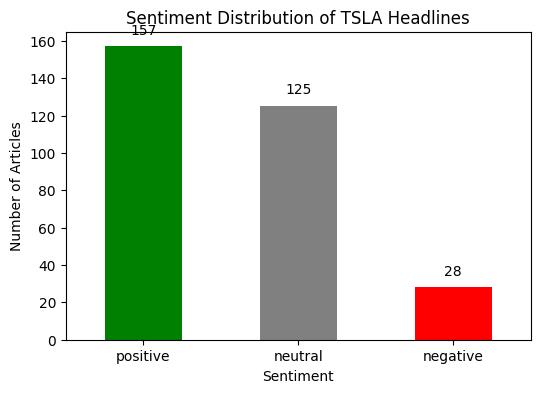

In [142]:
plot_sentiment(sentiment_counts, 'TSLA ')

In [143]:
tsla_related_data['Daily Returns'] = tsla_related_data['Close'].pct_change()

In [144]:
tsla_related_data[relevant_columns].head()

headline  polarity  \
Date                                                                      
2015-12-29  UBS Says 5 Most Shorted Stocks On Monday Were ...       0.0   
2011-05-04  Earnings Scheduled For May 4 (PCG, WFMI, TWX, ...       0.0   
2019-12-24  Benzinga Pro's Top 5 Stocks To Watch For Tues....       0.5   
2011-03-31  Benzinga's Volume Movers (TSLA, DNDN, ACXM, MAKO)       0.0   
2013-07-10  What to Expect From Tesla Shares After Joining...       0.0   

                Close  Daily Returns  
Date                                  
2015-12-29  15.812667            NaN  
2011-05-04   1.779333      -0.887474  
2019-12-24  28.350000      14.932937  
2011-03-31   1.850000      -0.934744  
2013-07-10   8.151333       3.406126

Correlation

In [145]:
correlation = tsla_related_data['polarity'].corr(tsla_related_data['Daily Returns'])
print("Correlation between sentiment and daily stock returns:", correlation)

Correlation between sentiment and daily stock returns: 0.16396149958644846


In [146]:
correlation = tsla_related_data['polarity'].corr(tsla_related_data['Close'])
print("Correlation between sentiment and closing:", correlation)

Correlation between sentiment and closing: 0.4449886073650206
